In [ ]:
!pip install nltk
!pip install spacy
!python -m spacy download es_core_news_sm
!pip install -U imbalanced-learn
!pip install pyspellchecker
!pip install svgutils
!pip install -U kaleido
!pip install -U plotly psutil requests orca
!pip install pscript

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import gensim
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')

from textblob import TextBlob
from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from IPython.display import display
from nltk.probability import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import os

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# **Extraer datos de los usarios**

In [ ]:
def cargar_documentos(ruta):
    documentos = []

    for archivo in os.listdir(ruta):
        if archivo.endswith(".tsv"):
            # Leer el archivo CSV usando pandas
            df = pd.read_csv(os.path.join(ruta, archivo), sep='\t')

            # Verificar si la columna "TWEET_TEXT" existe en el DataFrame
            if 'TWEET_TEXT' in df.columns:
                # Obtener solo la columna "tweet"
                tweets = df['TWEET_TEXT'].tolist()

                # Agregar los tweets a la lista de documentos
                documentos.extend(tweets)
    return documentos

def cargar_documentos_csv(ruta):
    documentos = []

    for archivo in os.listdir(ruta):
        if archivo.endswith(".csv"):
            # Leer el archivo CSV usando pandas
            df = pd.read_csv(os.path.join(ruta, archivo), delimiter=',')

            # Verificar si la columna "tweet" existe en el DataFrame
            if 'tweet' in df.columns:
                # Obtener solo la columna "tweet"
                tweets = df['tweet'].tolist()

                # Agregar los tweets a la lista de documentos
                documentos.extend(tweets)

    return documentos

In [ ]:
# Ruta de los usarios dignosticados con Ansiedad, Depresión y los usarios de Control

ruta_ans = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuarios con ansiedad/'
ruta_dep = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuarios con depresión/'
ruta_cont = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuario de control/'
#Ansiedad
Ans = cargar_documentos_csv(ruta_ans)
# Crear un DataFrame usando pandas
data_ansiedad = pd.DataFrame({'TWEET_TEXT': Ans })
#Depresióm
Dep = cargar_documentos(ruta_dep)
# Crear un DataFrame usando pandas
data_depresion = pd.DataFrame({'TWEET_TEXT': Dep})
#Control
Cont = cargar_documentos(ruta_cont)
# Crear un DataFrame usando pandas
data_control = pd.DataFrame({'TWEET_TEXT': Cont})

*DATOS CONTROL*

In [ ]:
data_control.info()
data_control.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239127 entries, 0 to 239126
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   TWEET_TEXT  239127 non-null  object
dtypes: object(1)
memory usage: 1.8+ MB


,TWEET_TEXT
0,Ottavis tiene un reality. Esto está sucediendo...
1,RT @bbimbi: Lula no irá a Curitiba a entregars...
2,RT @suzyqiu: 📦🔥 #CajaDeHerramientas capítulo 7...
3,"Ayer terminé de ver La Casa de Papel, y no le ..."
4,RT @latidosdelrock: Iluminame en esta eterna n...
5,"Cuando uno tiene sed, pero el agua no está cer..."
6,RT @rechimuzziok: Presidente ReySol Handel se ...
7,@Lara_Imhof Bravo amiga 👏💜
8,RT @FrasesSilvio: “Hay locuras que hicieron el...
9,Me siento como en un programa de Capusotto. ht...


*DATOS DEPRESIÓN*

In [ ]:
data_depresion.info()
data_depresion.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189665 entries, 0 to 189664
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   TWEET_TEXT  189665 non-null  object
dtypes: object(1)
memory usage: 1.4+ MB


,TWEET_TEXT
0,Empiezo a trabajar en una semana y no se de do...
1,Pronto lo sabré.
2,Me quiero morir si no estás donde estoy.
3,Que asco de vida.
4,Unos cuantos y a la cama.
5,Ojala todas las mierdas que me meto acaben ráp...
6,RT @YourFaveMuse: Nada peor que una mujer cria...
7,Ninguna actividad te entretiene.
8,"La ansiedad se ha apoderado de mi vida, y grac..."
9,"RT @beiirr97_: hoy tengo un bajón, que no me a..."


*DATOS ANSIEDAD*

In [ ]:
data_ansiedad.info()
data_ansiedad.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64906 entries, 0 to 64905
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   TWEET_TEXT  64906 non-null  object
dtypes: object(1)
memory usage: 507.2+ KB


,TWEET_TEXT
0,@USUARIO JAJAJAJAJA esa es una historia mal co...
1,@USUARIO al menos no atrasé a mi causa con su ...
2,que sería sino
3,me gusta la calle cuando hay gente
4,"odio que me manden audios de más de 2min, teng..."


**PREPARACIÓN DE DATOS Y LIMPIEZA**

In [ ]:
# Obtener las palabras vacías en español

nltk.download('stopwords')
stopwords_en = set(stopwords.words('spanish')) #las palabras vacías en español utilizando la biblioteca NLTK (palabras que no aportan mucho significado al texto)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Limpiar**

In [ ]:
import re
import string


def removeHTML(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, '', text)
        return cleantext
    else:
        return text  # Devolver el valor original si no es de tipo string

def clean(text):
    text = text.lower()  # Convertir el texto a minúsculas
    # Varios pasos de limpieza usando sub() para sustituir patrones encontrados por cadenas vacías o espacios, según corresponda
    text = re.sub('\[.*?\]', '', text)  # Eliminar texto entre corchetes
    text = re.sub("\\W"," ",text)  # Sustituir caracteres no alfanuméricos por espacios
    text = re.sub('https?://\S+|www\.\S+', '', text)  # Eliminar URLs
    text = re.sub('<.*?>+', '', text)  # Eliminar etiquetas HTML, redundante debido a la función removeHTML
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  # Eliminar puntuación
    text = re.sub('\n', '', text)  # Eliminar saltos de línea
    text = re.sub('\w*\d\w*', '', text)  # Eliminar palabras que contienen números
    text = re.sub(r'#\w+', '', text)  # Eliminar hashtags
    text = re.sub(r'@\w+', '', text)  # Eliminar menciones
    text = re.sub(r'\b[A-Z][a-z]+\b', '', text)  # Eliminar palabras que empiezan con mayúsculas (posiblemente nombres propios)
    text = re.sub(r'[^\w\s]+', '', text)  # Eliminar caracteres especiales
    text = re.sub(r'\b\w{1,2}\b|\d+', '', text)  # Eliminar palabras de 1 o 2 letras y números
    # Proceso de eliminación de emojis y caracteres especiales listados manualmente
    emojis = re.findall(r'[^\w\s,]', text)
    cleaned_emojis = [emoji for emoji in emojis if emoji not in [...]]  # Lista de emojis y caracteres a mantener o eliminar
    for emoji in cleaned_emojis:
        text = text.replace(emoji, '')  # Eliminar emojis y caracteres seleccionados
    return text  # Devolver el texto limpio



In [ ]:
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))

# Inicializar stemmer de NLTK
stemmer = PorterStemmer()

In [ ]:
import pandas as pd
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords


# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))
def extractTerms(text):
    if isinstance(text, str):
        # Tokenización y lematización con spaCy
        doc = nlp(text)
        lemmatized_terms = [token.lemma_ for token in doc if token.text.lower() not in stopwords_es]

        return lemmatized_terms
    else:
        return []  # Devolver una lista vacía si el texto no es una cadena de texto

# Ejemplo de uso
texto_ejemplo = "Me gustan los gatos están saltando sobre las vallas"
terminos_extraidos = extractTerms(texto_ejemplo)
print(terminos_extraidos)

['gustar', 'gato', 'saltar', 'valla']


# Limpieza de los datos

In [ ]:
# Control
data_control['TWEET_TEXT'] = data_control.TWEET_TEXT.apply(lambda x : removeHTML(x))
data_control['TWEET_TEXT'] = data_control.TWEET_TEXT.apply(lambda x : clean(x))
#Depresión
data_depresion['TWEET_TEXT'] = data_depresion.TWEET_TEXT.apply(lambda x : removeHTML(x))
data_depresion['TWEET_TEXT'] = data_depresion.TWEET_TEXT.apply(lambda x : clean(x))
#Ansiedad
data_ansiedad['TWEET_TEXT'] = data_ansiedad.TWEET_TEXT.apply(lambda x : removeHTML(x))
data_ansiedad['TWEET_TEXT'] = data_ansiedad.TWEET_TEXT.apply(lambda x : clean(x))

#Stop Words

In [ ]:
def Stopword(text):
  token_text = nltk.word_tokenize(text)  # Tokenizar el texto en palabras individuales
  remover_palab = [word for word in token_text if word not in stopwords_en]  # Filtrar las palabras, eliminando las stopwords
  join_text = ' '.join(remover_palab)  # Unir las palabras filtradas en una cadena de texto
  return join_text  # Devolver el texto procesado


In [ ]:
# Control
data_control['TWEET_TEXT'] = data_control.TWEET_TEXT.apply(lambda x : Stopword(x))

#Depresión
data_depresion['TWEET_TEXT'] = data_depresion.TWEET_TEXT.apply(lambda x : Stopword(x))

#Ansiedad
data_ansiedad['TWEET_TEXT'] = data_ansiedad.TWEET_TEXT.apply(lambda x : Stopword(x))


In [ ]:
#Depresión
data_depresion.head()


,TWEET_TEXT
0,empiezo trabajar semana voy sacar ganas
1,pronto sabré
2,quiero morir
3,asco vida
4,cuantos cama


In [ ]:
#Ansiedad
data_ansiedad.head()

,TWEET_TEXT
0,usuario jajajajaja historia mal contada
1,usuario menos atrasé causa flaca
2,sino
3,gusta calle gente
4,odio manden audios tdah puedo prestar atención...


# Lematización

depresión

In [ ]:
data_depresion['TWEET_TEXT'] = data_depresion.TWEET_TEXT.apply(lambda x : extractTerms(x))


In [ ]:
data_depresion['TWEET_TEXT'] = data_depresion['TWEET_TEXT'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x) # Combinar los elementos de la lista en una sola cadena separados por espacios

In [ ]:
data_depresion.info()
data_depresion.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189665 entries, 0 to 189664
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   TWEET_TEXT  189665 non-null  object
dtypes: object(1)
memory usage: 1.4+ MB


,TWEET_TEXT
0,empiezo trabajar semana voy sacar ganas
1,pronto sabré
2,quiero morir
3,asco vida
4,cuantos cama


ansiedad

In [ ]:
data_ansiedad['TWEET_TEXT'] = data_ansiedad.TWEET_TEXT.apply(lambda x : extractTerms(x))


In [ ]:
data_ansiedad['TWEET_TEXT'] = data_ansiedad['TWEET_TEXT'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
data_ansiedad.info()
data_ansiedad.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64906 entries, 0 to 64905
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   TWEET_TEXT  64906 non-null  object
dtypes: object(1)
memory usage: 507.2+ KB


,TWEET_TEXT
0,usuario jajajajaja historia mal contada
1,usuario menos atrasé causa flaca
2,sino
3,gusta calle gente
4,odio manden audios tdah puedo prestar atención...


# **Conteo de las palabras más comunes dichas por los psicologos en la encuenta en los tweets de los usuarios**

**Palabras depresión:** Tristeza, Soledad, Vacío, Desánimo, Desmotivación, Desesperanza, Aislamiento, Melancolía, Dolor y Fatiga

In [ ]:
# Lista de palabras
lista_palabras = ["Tristeza", "Soledad", "Vacío", "Desánimo", "Desmotivación", "Desesperanza", "Aislamiento", "Melancolía", "Dolor", "Fatiga"]

# Crear un diccionario para almacenar la frecuencia de cada palabra
frecuencia_palabras = {palabra: 0 for palabra in lista_palabras}

# Iterar sobre cada tweet en el DataFrame
for tweet in data_depresion['TWEET_TEXT']:
    # Convertir el texto a minúsculas para realizar una búsqueda sin distinción entre mayúsculas y minúsculas
    tweet = tweet.lower()

    # Iterar sobre cada palabra en la lista
    for palabra in lista_palabras:
        # Utilizar expresiones regulares para encontrar coincidencias de palabras completas
        coincidencias = re.findall(r'\b' + re.escape(palabra.lower()) + r'\b', tweet)

        # Incrementar la frecuencia si se encontraron coincidencias
        frecuencia_palabras[palabra] += len(coincidencias)

# Mostrar la frecuencia de cada palabra
for palabra, frecuencia in frecuencia_palabras.items():
    print(f'{palabra}: {frecuencia}')

Tristeza: 877
Soledad: 475
Vacío: 618
Desánimo: 4
Desmotivación: 2
Desesperanza: 4
Aislamiento: 4
Melancolía: 15
Dolor: 1843
Fatiga: 3


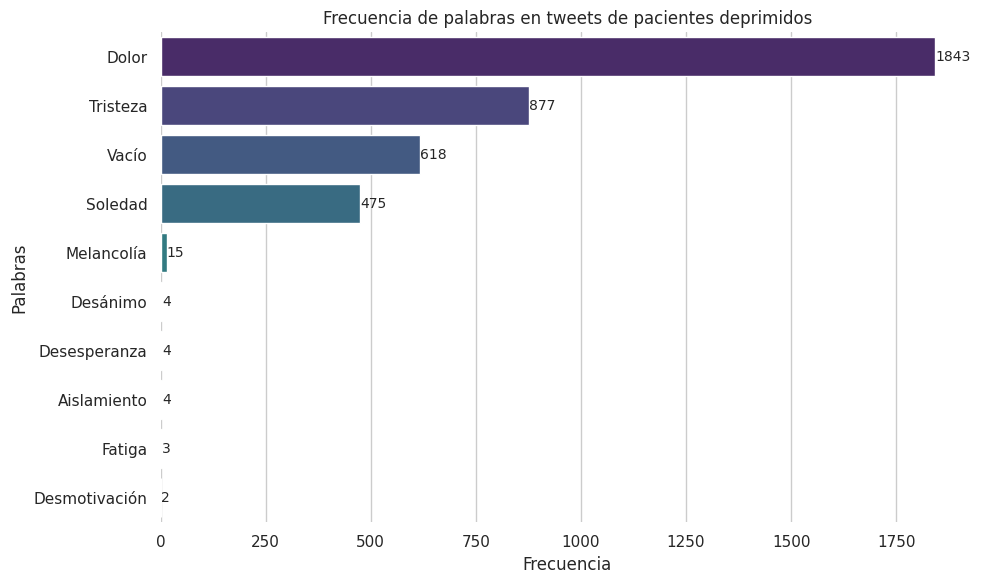

In [ ]:
# Convertir a DataFrame para usar Seaborn
df_frecuencia = pd.DataFrame(list(frecuencia_palabras.items()), columns=['Palabra', 'Frecuencia'])

# Ordenar por frecuencia descendente
df_frecuencia = df_frecuencia.sort_values(by='Frecuencia', ascending=False)

# Configurar estilo de Seaborn
sns.set(style="whitegrid")

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 6))

# Graficar la frecuencia
barplot = sns.barplot(x='Frecuencia', y='Palabra', data=df_frecuencia, palette="viridis")

# Configurar etiquetas y título
barplot.set(xlabel='Frecuencia', ylabel='Palabras', title='Frecuencia de palabras en tweets de pacientes deprimidos')

# Mostrar valores en las barras
for index, value in enumerate(df_frecuencia['Frecuencia']):
    barplot.text(value, index, str(value), ha='left', va='center', fontsize=10)

# Ajustar diseño y mostrar la gráfica
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

**Palabras ansiedad:** Preocupación, "Nerviosismo, "Estrés, Incertidumbre, Miedo, Ansiedad, Inquietud, Pánico, Temor y Agobio

In [ ]:
# Lista de palabras para ansiedad
lista_palabras = ["Preocupación", "Nerviosismo", "Estrés", "Incertidumbre", "Miedo", "Ansiedad", "Inquietud", "Pánico", "Temor", "Agobio"]
# Crear un diccionario para almacenar la frecuencia de cada palabra
frecuencia_palabras = {palabra: 0 for palabra in lista_palabras}

# Iterar sobre cada tweet en el DataFrame
for tweet in data_ansiedad['TWEET_TEXT']:
    # Convertir el texto a minúsculas para realizar una búsqueda sin distinción entre mayúsculas y minúsculas
    tweet = tweet.lower()

    # Iterar sobre cada palabra en la lista
    for palabra in lista_palabras:
        # Utilizar expresiones regulares para encontrar coincidencias de palabras completas
        coincidencias = re.findall(r'\b' + re.escape(palabra.lower()) + r'\b', tweet)

        # Incrementar la frecuencia si se encontraron coincidencias
        frecuencia_palabras[palabra] += len(coincidencias)

# Mostrar la frecuencia de cada palabra
for palabra, frecuencia in frecuencia_palabras.items():
    print(f'{palabra}: {frecuencia}')

Preocupación: 12
Nerviosismo: 3
Estrés: 62
Incertidumbre: 5
Miedo: 468
Ansiedad: 402
Inquietud: 1
Pánico: 65
Temor: 8
Agobio: 5


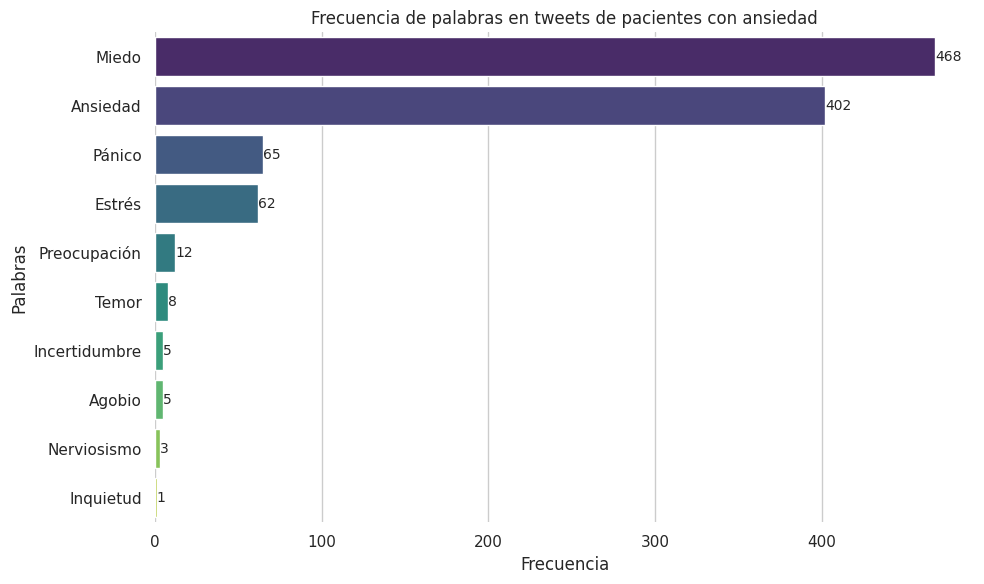

In [ ]:
# Convertir a DataFrame para usar Seaborn
df_frecuencia = pd.DataFrame(list(frecuencia_palabras.items()), columns=['Palabra', 'Frecuencia'])

# Ordenar por frecuencia descendente
df_frecuencia = df_frecuencia.sort_values(by='Frecuencia', ascending=False)

# Configurar estilo de Seaborn
sns.set(style="whitegrid")

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 6))

# Graficar la frecuencia
barplot = sns.barplot(x='Frecuencia', y='Palabra', data=df_frecuencia, palette="viridis")

# Configurar etiquetas y título
barplot.set(xlabel='Frecuencia', ylabel='Palabras', title='Frecuencia de palabras en tweets de pacientes con ansiedad')

# Mostrar valores en las barras
for index, value in enumerate(df_frecuencia['Frecuencia']):
    barplot.text(value, index, str(value), ha='left', va='center', fontsize=10)

# Ajustar diseño y mostrar la gráfica
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

# **CREACIÓN Y ENTRENAMIENTO DE MODELOS A PARTIR DE LAS PALABRAS DICHAS POR LOS PSICOLOGOS**

# BOW

In [ ]:
from keras.preprocessing.text import Tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [ ]:
def load_doc(filename):
    try:
        data = pd.read_csv(filename, delimiter=';')
        return data
    except Exception as e:
        print("Error:", e)
        return None

In [ ]:
def doc_to_line(filename, vocab):
  doc = load_doc(filename)
  tokens = clean(doc)
  tokens = [w for w in tokens if w in vocab]
  return ' '.join(tokens)

In [ ]:
def process_docs(directory, vocab, is_train):
    lines = list()
    for filename in os.listdir(directory):
        if is_train and filename.startswith('(72)'):
            continue  # Omitir archivos de prueba en el conjunto de entrenamiento
        if not is_train and not filename.startswith('(72)'):
            continue  # Omitir archivos de entrenamiento en el conjunto de prueba
        path = os.path.join(directory, filename)
        doc = load_doc(path)
        line = doc_to_line(doc, vocab)
        lines.append(line)
    return lines

In [ ]:
# Lista de palabras
lista_palabras = ["Tristeza", "Soledad", "Vacío", "Desánimo", "Desmotivación", "Desesperanza", "Aislamiento", "Melancolía", "Dolor", "Fatiga"]

# Convertir la lista de palabras a un conjunto para eliminar duplicados
vocabulario = set(lista_palabras)

# Ruta del archivo para guardar el vocabulario
vocab_filename = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/vocab_d.txt'

# Guardar el vocabulario en el archivo
with open(vocab_filename, 'w') as file:
    for palabra in vocabulario:
        file.write(f"{palabra}\n")

# Imprimir el vocabulario
print("Vocabulario creado y guardado en el archivo:")
print(vocabulario)


Vocabulario creado y guardado en el archivo:
{'Soledad', 'Desánimo', 'Vacío', 'Melancolía', 'Fatiga', 'Desmotivación', 'Tristeza', 'Desesperanza', 'Dolor', 'Aislamiento'}


In [ ]:
vocab_filename = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/vocab_d.txt'
with open(vocab_filename, 'r') as file:
    vocab_content = file.read()

vocab = vocab_content.split()
vocab = set(vocab)
print(vocab)

{'Soledad', 'Desánimo', 'Vacío', 'Melancolía', 'Fatiga', 'Desmotivación', 'Tristeza', 'Desesperanza', 'Dolor', 'Aislamiento'}


In [ ]:
import array
#Del mismo modo, la función load_clean_dataset() debe actualizarse para cargar el entrenamiento o prueba
# y asegúrarse de que devuelva una matriz Numpy
def load_clean_dataset(vocab, is_train):
  Dep = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuarios con depresión/', vocab, is_train)
  Cont = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuario de control/', vocab, is_train)
  docs = Dep + Cont
  labels = np.array([1 for _ in range(len(Dep))] + [0 for _ in range(len(Cont))])
  return docs, labels

In [ ]:
def process_docs(directory, vocab, is_train):
    lines = list()
    for filename in os.listdir(directory):
        path = os.path.join(directory, filename)
        if os.path.isfile(path):  # Verificar si es un archivo antes de procesarlo
            doc = load_doc(path)
            line = ' '.join(clean(doc))
            lines.append(line)
    return lines

def load_doc(filename):
    with open(filename, 'r') as file:
        text = file.read()
    return text

In [ ]:
import os
import joblib
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

vocab_filename = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/vocab_d.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

train_docs, y = load_clean_dataset(vocab, True)
test_docs, y_test = load_clean_dataset(vocab, False)

tokenizer = create_tokenizer(train_docs)
x = tokenizer.texts_to_matrix(train_docs, mode='binary')
x_test = tokenizer.texts_to_matrix(test_docs, mode='binary')


# Dividir los datos en conjuntos de entrenamiento (70%) y validación (30%)
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)


In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(126, 551)
(54, 551)
(126,)
(54,)


#**Red neuronal**

In [ ]:
# Crear una red neuronal secuencial
model = Sequential()

# Agregar una capa de entrada con el número de características (vocabulario) en tu matriz TF-IDF
model.add(Dense(328, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa oculta
model.add(Dense(164, activation='relu'))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa de salida con una neurona y función de activación sigmoide para clasificación binaria
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo en los datos de entrenamiento
history = model.fit(X_train, y_train, epochs=100, batch_size=50, validation_data=(X_val, y_val))

# Evaluar el modelo en el conjunto de validación
y_val_pred = (model.predict(X_val) > 0.5).astype(int)

# Calcular métricas de evaluación en el conjunto de validación
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Calcular métricas de evaluación en el conjunto de entrenamiento
y_train_pred = (model.predict(X_train) > 0.5).astype(int)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

Epoch 1/100
3/3 [==============================] - 1s 131ms/step - loss: 0.6888 - accuracy: 0.5714 - val_loss: 0.6495 - val_accuracy: 0.7222
Epoch 2/100
3/3 [==============================] - 0s 23ms/step - loss: 0.6204 - accuracy: 0.6905 - val_loss: 0.6152 - val_accuracy: 0.7222
Epoch 3/100
3/3 [==============================] - 0s 29ms/step - loss: 0.5948 - accuracy: 0.7381 - val_loss: 0.5881 - val_accuracy: 0.7593
Epoch 4/100
3/3 [==============================] - 0s 22ms/step - loss: 0.5554 - accuracy: 0.7302 - val_loss: 0.5742 - val_accuracy: 0.7407
Epoch 5/100
3/3 [==============================] - 0s 33ms/step - loss: 0.5124 - accuracy: 0.7698 - val_loss: 0.5679 - val_accuracy: 0.7593
Epoch 6/100
3/3 [==============================] - 0s 22ms/step - loss: 0.5030 - accuracy: 0.7619 - val_loss: 0.5743 - val_accuracy: 0.7593
Epoch 7/100
3/3 [==============================] - 0s 22ms/step - loss: 0.4626 - accuracy: 0.8095 - val_loss: 0.6004 - val_accuracy: 0.7222
Epoch 8/100
3/3 [==

In [ ]:
# Imprimir métricas de entrenamiento
print("\nMétricas en el conjunto de entrenamiento:")
print(f"Exactitud (entrenamiento): {round(accuracy_train, 2) * 100}%")
print(f"Precisión (entrenamiento): {round(precision_train, 2) * 100}%")
print(f"Recall (entrenamiento): {round(recall_train, 2) * 100}%")
print(f"F1-score (entrenamiento): {round(f1_train, 2) * 100}%")
print('-------------------------------------------------------------------------')
# Imprimir métricas de evaluación
print(f"Exactitud en el conjunto de validación: {round(accuracy, 2) * 100}%")
print(f"Precisión en el conjunto de validación: {round(precision, 2) * 100}%")
print(f"Recall en el conjunto de validación: {round(recall, 2) * 100}%")
print(f"F1-score en el conjunto de validación: {round(f1, 2) * 100}%")


Métricas en el conjunto de entrenamiento:
Exactitud (entrenamiento): 90.0%
Precisión (entrenamiento): 83.0%
Recall (entrenamiento): 100.0%
F1-score (entrenamiento): 91.0%
-------------------------------------------------------------------------
Exactitud en el conjunto de validación: 70.0%
Precisión en el conjunto de validación: 65.0%
Recall en el conjunto de validación: 80.0%
F1-score en el conjunto de validación: 71.0%


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

2/2 [==============================] - 0s 6ms/step
Matriz de confusión: 

 [[18 11]
 [ 5 20]] 

Proporción de comentarios positivos: 0.46
Proporción de comentarios positivos etiquetados: 0.57


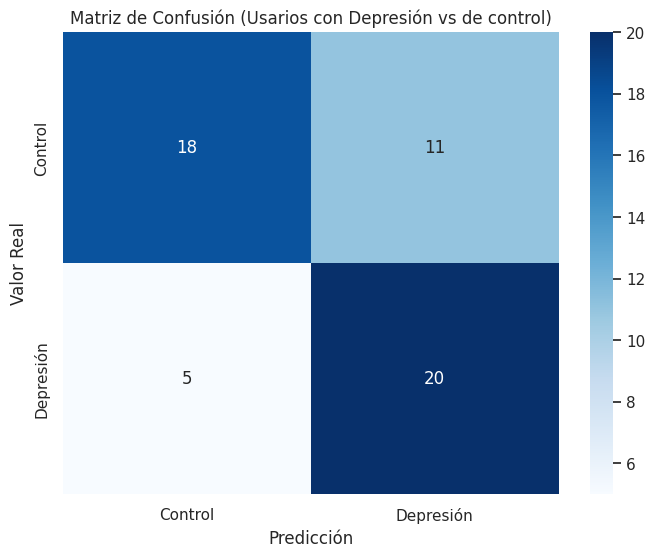

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Depresión'], yticklabels=['Control', 'Depresión'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Usarios con Depresión vs de control)')

# Mostrar la gráfica
plt.show()

#Modelo Arbol Aleatorio

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Importa las librerías necesarias y divide los datos en conjuntos de entrenamiento y validación
from sklearn.model_selection import train_test_split

# X_train, X_val, y_train, y_val

# Crea un modelo de Random Forest
random_forest_model = RandomForestClassifier(n_estimators=300,  # Numero de alboles
                                             max_depth=100, # profunidad máxima
                                             random_state=42)  # selección de la semilla de manera aleatoria


# Entrena el modelo en los datos de entrenamiento
random_forest_model.fit(X_train, y_train)

# Realiza predicciones en los datos de validación
y_val_pred = random_forest_model.predict(X_val)

# Calcula la precisión (accuracy) del modelo en los datos de validación
accuracy = accuracy_score(y_val, y_val_pred)
print("Accuracy (validación): {:.2f}".format(accuracy))

# Calcula la precisión del modelo en los datos de validación
precision = precision_score(y_val, y_val_pred)
print("Precision (validación): {:.2f}".format(precision))

# Calcula la exactitud (recall) del modelo en los datos de validación
recall = recall_score(y_val, y_val_pred)
print("Recall (validación): {:.2f}".format(recall))

# Calcula el F1-score del modelo en los datos de validación
f1 = f1_score(y_val, y_val_pred)
print("F1-score (validación): {:.2f}".format(f1))

# Calcula y muestra métricas en el conjunto de entrenamiento
y_train_pred = random_forest_model.predict(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

#




Accuracy (validación): 0.72
Precision (validación): 0.67
Recall (validación): 0.80
F1-score (validación): 0.73


In [ ]:
# Imprimir las métricas de entrenamiento
print(f'Accuracy entrenamiento: {accuracy_train * 100:.2f}%')
print(f'Precisión  entrenamiento: {precision_train * 100:.2f}%')
print(f'Recall  entrenamiento: {recall_train * 100:.2f}%')
print(f'Puntuación F1  entrenamiento: {f1_train * 100:.2f}%')
print('\n')
# Imprimir las métricas de validación
print(f'Accuracy  validación: {accuracy * 100:.2f}%')
print(f'Precisión  validación: {precision* 100:.2f}%')
print(f'Recall  validación: {recall* 100:.2f}%')
print(f'Puntuación F1 validación: {f1 * 100:.2f}%')

Accuracy entrenamiento: 90.48%
Precisión  entrenamiento: 84.42%
Recall  entrenamiento: 100.00%
Puntuación F1  entrenamiento: 91.55%


Accuracy  validación: 72.22%
Precisión  validación: 66.67%
Recall  validación: 80.00%
Puntuación F1 validación: 72.73%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_RF = random_forest_model.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred_RF > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[19 10]
 [ 5 20]] 

Proporción de comentarios positivos: 0.46
Proporción de comentarios positivos etiquetados: 0.56


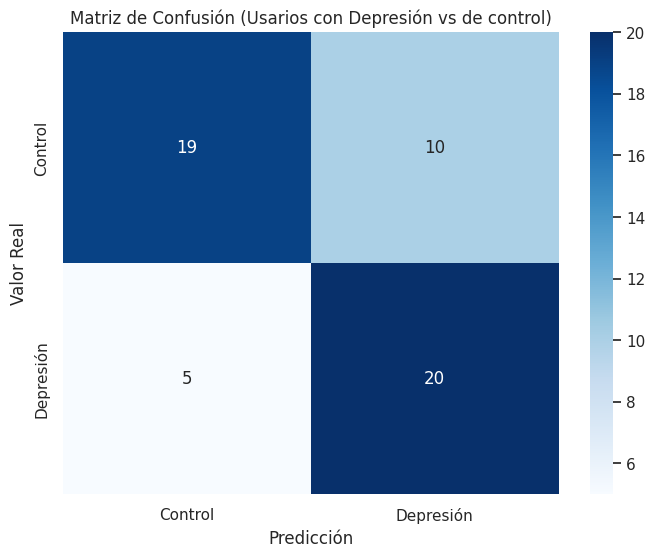

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Depresión'], yticklabels=['Control', 'Depresión'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Usarios con Depresión vs de control)')

# Mostrar la gráfica
plt.show()

#Modelo SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import os

svm_model_p = SVC(kernel='linear', degree=4, C=100, max_iter=100000, probability=False)

# Entrenar el modelo en los datos de entrenamiento
svm_model_p.fit(X_train, y_train)

# Predecir etiquetas en el conjunto de validación
y_val_pred = svm_model_p.predict(X_val)

# Calcula la precisión del modelo en el conjunto de validación
accuracy = accuracy_score(y_val, y_val_pred)


# Calcula precisión, exhaustividad y puntuación F1 en el conjunto de validación
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Calcula y muestra métricas en el conjunto de entrenamiento
y_train_pred = svm_model_p.predict(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

print("\nEntrenamiento:")
print("Exactitud (entrenamiento): {:.2f}%".format(accuracy_train*100))
print("Precision (entrenamiento): {:.2f}%".format(precision_train*100))
print("Recall (entrenamiento): {:.2f}%".format(recall_train*100))
print("F1-score (entrenamiento): {:.2f}%".format(f1_train*100))
print("\nValidación:")
print(f"Exactitud en el conjunto de validación: {round(accuracy,2)*100}%")
print(f"Precisión en el conjunto de validación:{round(precision,2)*100}%")
print(f"Recall en el conjunto de validación: {round(recall,2)*100}%")
print(f"F1-score en el conjunto de validación:{round(f1,2)*100}%")




Entrenamiento:
Exactitud (entrenamiento): 88.10%
Precision (entrenamiento): 82.05%
Recall (entrenamiento): 98.46%
F1-score (entrenamiento): 89.51%

Validación:
Exactitud en el conjunto de validación: 80.0%
Precisión en el conjunto de validación:72.0%
Recall en el conjunto de validación: 92.0%
F1-score en el conjunto de validación:81.0%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_RF = svm_model_p.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred_RF > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[20  9]
 [ 2 23]] 

Proporción de comentarios positivos: 0.46
Proporción de comentarios positivos etiquetados: 0.59


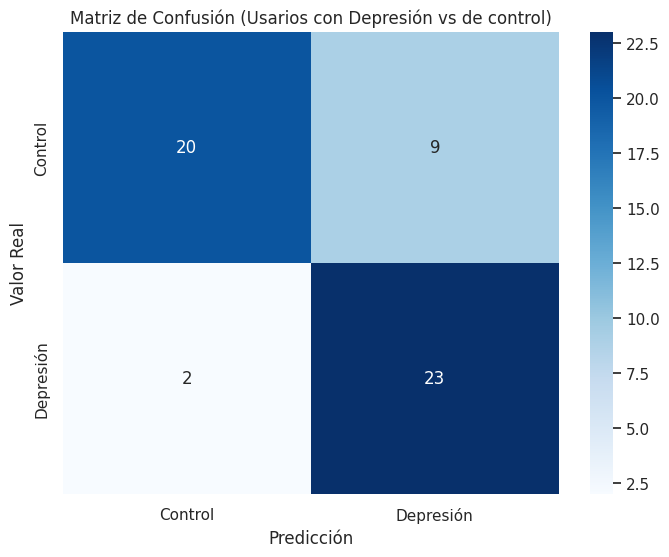

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Depresión'], yticklabels=['Control', 'Depresión'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Usarios con Depresión vs de control)')

# Mostrar la gráfica
plt.show()

# **Regresión Logistica**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
# Crear el modelo de regresión logística
lr_model = LogisticRegression(C=10)
lr_model.fit(X_train, y_train)

# Calcular el porcentaje de acierto en el conjunto de entrenamiento
accuracy_train = lr_model.score(X_train, y_train) * 100

# Calcular el porcentaje de acierto en el conjunto de validación
accuracy_val = lr_model.score(X_val, y_val) * 100

# Predicciones en el conjunto de entrenamiento y validación
y_train_pred = lr_model.predict(X_train)
y_val_pred = lr_model.predict(X_val)

# Calcular precisión en el conjunto de entrenamiento y validación
precision_train = precision_score(y_train, y_train_pred)* 100
precision_val = precision_score(y_val, y_val_pred)* 100

# Calcular exhaustividad (recall) en el conjunto de entrenamiento y validación
recall_train = recall_score(y_train, y_train_pred)* 100
recall_val = recall_score(y_val, y_val_pred)* 100

# Calcular puntuación F1 en el conjunto de entrenamiento y validación
f1_train = f1_score(y_train, y_train_pred)* 100
f1_val = f1_score(y_val, y_val_pred)* 100


In [ ]:
# Mostrar métricas de entrenamiento
print("Métricas de entrenamiento:")
print("Exactitud (entrenamiento): {:.2f}%".format(accuracy_train))
print("Precisión (entrenamiento): {:.2f}%".format(precision_train))
print("Exhaustividad (entrenamiento): {:.2f}%".format(recall_train))
print("Puntuación F1 (entrenamiento): {:.2f}%".format(f1_train))
print('-'*40)
# Mostrar métricas de validación
print("\nMétricas de validación:")
print("Exactitud (validación): {:.2f}%".format(accuracy_val))
print("Precisión (validación): {:.2f}%".format(precision_val))
print("Exhaustividad (validación): {:.2f}%".format(recall_val))
print("Puntuación F1 (validación): {:.2f}%".format(f1_val))

Métricas de entrenamiento:
Exactitud (entrenamiento): 88.10%
Precisión (entrenamiento): 82.05%
Exhaustividad (entrenamiento): 98.46%
Puntuación F1 (entrenamiento): 89.51%
----------------------------------------

Métricas de validación:
Exactitud (validación): 77.78%
Precisión (validación): 70.97%
Exhaustividad (validación): 88.00%
Puntuación F1 (validación): 78.57%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_RF = lr_model.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred_RF > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[20  9]
 [ 3 22]] 

Proporción de comentarios positivos: 0.46
Proporción de comentarios positivos etiquetados: 0.57


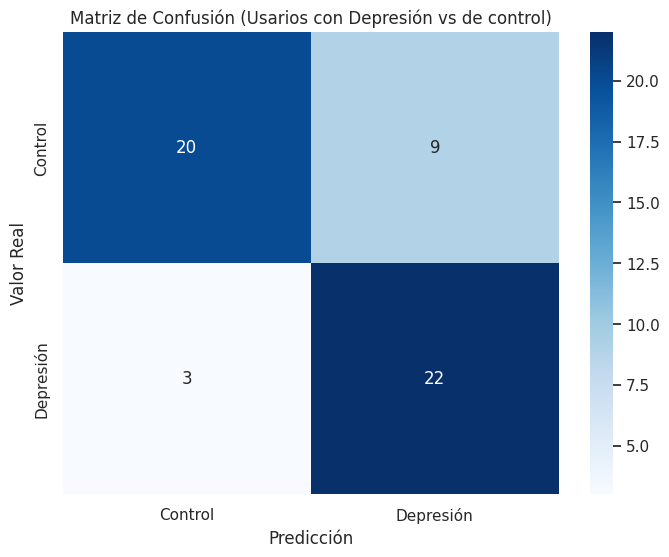

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Depresión'], yticklabels=['Control', 'Depresión'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Usarios con Depresión vs de control)')

# Mostrar la gráfica
plt.show()

**Ansiedad**

In [ ]:
# Lista de palabras
lista_palabras  = ["Preocupación", "Nerviosismo", "Estrés", "Incertidumbre", "Miedo", "Ansiedad", "Inquietud", "Pánico", "Temor", "Agobio"]

# Convertir la lista de palabras a un conjunto para eliminar duplicados
vocabulario = set(lista_palabras)

# Ruta del archivo para guardar el vocabulario
vocab_filename = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/vocab_A.txt'

# Guardar el vocabulario en el archivo
with open(vocab_filename, 'w') as file:
    for palabra in vocabulario:
        file.write(f"{palabra}\n")

# Imprimir el vocabulario
print("Vocabulario creado y guardado en el archivo:")
print(vocabulario)


Vocabulario creado y guardado en el archivo:
{'Preocupación', 'Incertidumbre', 'Pánico', 'Inquietud', 'Ansiedad', 'Temor', 'Estrés', 'Agobio', 'Nerviosismo', 'Miedo'}


In [ ]:
vocab_filename = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/vocab_A.txt'
with open(vocab_filename, 'r') as file:
    vocab_content = file.read()

vocab = vocab_content.split()
vocab = set(vocab)
print(vocab)

{'Preocupación', 'Incertidumbre', 'Pánico', 'Inquietud', 'Ansiedad', 'Temor', 'Estrés', 'Agobio', 'Nerviosismo', 'Miedo'}


In [ ]:
import array
#Del mismo modo, la función load_clean_dataset() debe actualizarse para cargar el entrenamiento o prueba
# y asegúrarse de que devuelva una matriz Numpy
def load_clean_dataset(vocab, is_train):
  Dep = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuarios con ansiedad/', vocab, is_train)
  Cont = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuario de control/', vocab, is_train)
  docs = Dep + Cont
  labels = np.array([1 for _ in range(len(Dep))] + [0 for _ in range(len(Cont))])
  return docs, labels

In [ ]:
def process_docs(directory, vocab, is_train):
    lines = list()
    for filename in os.listdir(directory):
        path = os.path.join(directory, filename)
        if os.path.isfile(path):  # Verificar si es un archivo antes de procesarlo
            doc = load_doc(path)
            line = ' '.join(clean(doc))
            lines.append(line)
    return lines

def load_doc(filename):
    with open(filename, 'r') as file:
        text = file.read()
    return text

In [ ]:
import os
import joblib
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

vocab_filename = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/vocab_A.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

train_docs, y = load_clean_dataset(vocab, True)
test_docs, y_test = load_clean_dataset(vocab, False)

tokenizer = create_tokenizer(train_docs)
x = tokenizer.texts_to_matrix(train_docs, mode='binary')
x_test = tokenizer.texts_to_matrix(test_docs, mode='binary')


# Dividir los datos en conjuntos de entrenamiento (70%) y validación (30%)
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)


In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(126, 569)
(54, 569)
(126,)
(54,)


#**Red neuronal**

In [ ]:
# Crear una red neuronal secuencial
model = Sequential()

# Agregar una capa de entrada con el número de características (vocabulario) en tu matriz TF-IDF
model.add(Dense(328, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa oculta
model.add(Dense(164, activation='relu'))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa de salida con una neurona y función de activación sigmoide para clasificación binaria
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo en los datos de entrenamiento
history = model.fit(X_train, y_train, epochs=100, batch_size=50, validation_data=(X_val, y_val))

# Evaluar el modelo en el conjunto de validación
y_val_pred = (model.predict(X_val) > 0.5).astype(int)

# Calcular métricas de evaluación en el conjunto de validación
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Calcular métricas de evaluación en el conjunto de entrenamiento
y_train_pred = (model.predict(X_train) > 0.5).astype(int)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

Epoch 1/100
3/3 [==============================] - 2s 188ms/step - loss: 0.6714 - accuracy: 0.5952 - val_loss: 0.6242 - val_accuracy: 0.8333
Epoch 2/100
3/3 [==============================] - 0s 58ms/step - loss: 0.5999 - accuracy: 0.8016 - val_loss: 0.5665 - val_accuracy: 0.8519
Epoch 3/100
3/3 [==============================] - 0s 52ms/step - loss: 0.5508 - accuracy: 0.8413 - val_loss: 0.5191 - val_accuracy: 0.8704
Epoch 4/100
3/3 [==============================] - 0s 38ms/step - loss: 0.5130 - accuracy: 0.8175 - val_loss: 0.4690 - val_accuracy: 0.8704
Epoch 5/100
3/3 [==============================] - 0s 54ms/step - loss: 0.4666 - accuracy: 0.8492 - val_loss: 0.4297 - val_accuracy: 0.8519
Epoch 6/100
3/3 [==============================] - 0s 44ms/step - loss: 0.4199 - accuracy: 0.8333 - val_loss: 0.3913 - val_accuracy: 0.8889
Epoch 7/100
3/3 [==============================] - 0s 48ms/step - loss: 0.3974 - accuracy: 0.8571 - val_loss: 0.3676 - val_accuracy: 0.8704
Epoch 8/100
3/3 [==

In [ ]:
# Imprimir métricas de entrenamiento
print("\nMétricas en el conjunto de entrenamiento:")
print(f"Exactitud (entrenamiento): {round(accuracy_train, 2) * 100}%")
print(f"Precisión (entrenamiento): {round(precision_train, 2) * 100}%")
print(f"Recall (entrenamiento): {round(recall_train, 2) * 100}%")
print(f"F1-score (entrenamiento): {round(f1_train, 2) * 100}%")
print('-------------------------------------------------------------------------')
# Imprimir métricas de evaluación
print(f"Exactitud en el conjunto de validación: {round(accuracy, 2) * 100}%")
print(f"Precisión en el conjunto de validación: {round(precision, 2) * 100}%")
print(f"Recall en el conjunto de validación: {round(recall, 2) * 100}%")
print(f"F1-score en el conjunto de validación: {round(f1, 2) * 100}%")


Métricas en el conjunto de entrenamiento:
Exactitud (entrenamiento): 89.0%
Precisión (entrenamiento): 85.0%
Recall (entrenamiento): 95.0%
F1-score (entrenamiento): 90.0%
-------------------------------------------------------------------------
Exactitud en el conjunto de validación: 87.0%
Precisión en el conjunto de validación: 82.0%
Recall en el conjunto de validación: 92.0%
F1-score en el conjunto de validación: 87.0%


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

2/2 [==============================] - 0s 6ms/step
Matriz de confusión: 

 [[24  5]
 [ 2 23]] 

Proporción de comentarios positivos: 0.46
Proporción de comentarios positivos etiquetados: 0.52


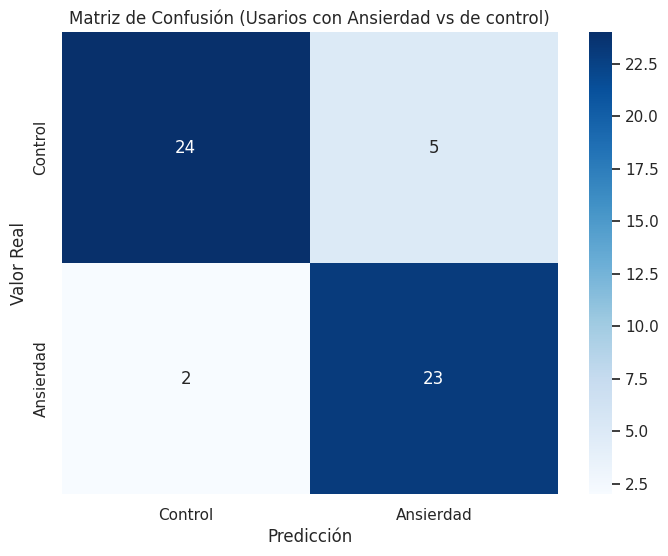

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Ansierdad'], yticklabels=['Control', 'Ansierdad'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Usarios con Ansierdad vs de control)')

# Mostrar la gráfica
plt.show()

#Modelo Arbol Aleatorio

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Importa las librerías necesarias y divide los datos en conjuntos de entrenamiento y validación
from sklearn.model_selection import train_test_split

# X_train, X_val, y_train, y_val

# Crea un modelo de Random Forest
random_forest_model = RandomForestClassifier(n_estimators=300,  # Numero de alboles
                                             max_depth=100, # profunidad máxima
                                             random_state=42)  # selección de la semilla de manera aleatoria


# Entrena el modelo en los datos de entrenamiento
random_forest_model.fit(X_train, y_train)

# Realiza predicciones en los datos de validación
y_val_pred = random_forest_model.predict(X_val)

# Calcula la precisión (accuracy) del modelo en los datos de validación
accuracy = accuracy_score(y_val, y_val_pred)
print("Accuracy (validación): {:.2f}".format(accuracy))

# Calcula la precisión del modelo en los datos de validación
precision = precision_score(y_val, y_val_pred)
print("Precision (validación): {:.2f}".format(precision))

# Calcula la exactitud (recall) del modelo en los datos de validación
recall = recall_score(y_val, y_val_pred)
print("Recall (validación): {:.2f}".format(recall))

# Calcula el F1-score del modelo en los datos de validación
f1 = f1_score(y_val, y_val_pred)
print("F1-score (validación): {:.2f}".format(f1))

# Calcula y muestra métricas en el conjunto de entrenamiento
y_train_pred = random_forest_model.predict(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

#




Accuracy (validación): 0.91
Precision (validación): 0.83
Recall (validación): 1.00
F1-score (validación): 0.91


In [ ]:
# Imprimir las métricas de entrenamiento
print(f'Accuracy entrenamiento: {accuracy_train * 100:.2f}%')
print(f'Precisión  entrenamiento: {precision_train * 100:.2f}%')
print(f'Recall  entrenamiento: {recall_train * 100:.2f}%')
print(f'Puntuación F1  entrenamiento: {f1_train * 100:.2f}%')
print('\n')
# Imprimir las métricas de validación
print(f'Accuracy  validación: {accuracy * 100:.2f}%')
print(f'Precisión  validación: {precision* 100:.2f}%')
print(f'Recall  validación: {recall* 100:.2f}%')
print(f'Puntuación F1 validación: {f1 * 100:.2f}%')

Accuracy entrenamiento: 88.89%
Precisión  entrenamiento: 83.12%
Recall  entrenamiento: 98.46%
Puntuación F1  entrenamiento: 90.14%


Accuracy  validación: 90.74%
Precisión  validación: 83.33%
Recall  validación: 100.00%
Puntuación F1 validación: 90.91%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_RF = random_forest_model.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred_RF > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[24  5]
 [ 0 25]] 

Proporción de comentarios positivos: 0.46
Proporción de comentarios positivos etiquetados: 0.56


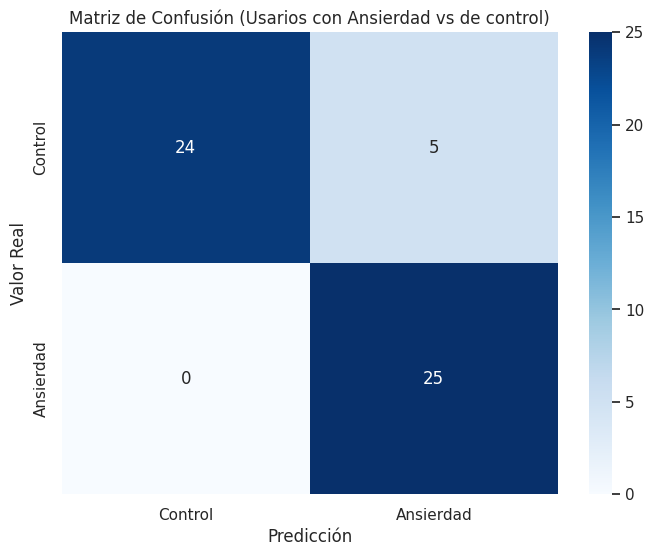

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Ansierdad'], yticklabels=['Control', 'Ansierdad'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Usarios con Ansierdad vs de control)')

# Mostrar la gráfica
plt.show()

#Modelo SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import os

svm_model_p = SVC(kernel='linear', degree=4, C=100, max_iter=100000, probability=False)

# Entrenar el modelo en los datos de entrenamiento
svm_model_p.fit(X_train, y_train)

# Predecir etiquetas en el conjunto de validación
y_val_pred = svm_model_p.predict(X_val)

# Calcula la precisión del modelo en el conjunto de validación
accuracy = accuracy_score(y_val, y_val_pred)


# Calcula precisión, exhaustividad y puntuación F1 en el conjunto de validación
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Calcula y muestra métricas en el conjunto de entrenamiento
y_train_pred = svm_model_p.predict(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

print("\nEntrenamiento:")
print("Exactitud (entrenamiento): {:.2f}%".format(accuracy_train*100))
print("Precision (entrenamiento): {:.2f}%".format(precision_train*100))
print("Recall (entrenamiento): {:.2f}%".format(recall_train*100))
print("F1-score (entrenamiento): {:.2f}%".format(f1_train*100))
print("\nValidación:")
print(f"Exactitud en el conjunto de validación: {round(accuracy,2)*100}%")
print(f"Precisión en el conjunto de validación:{round(precision,2)*100}%")
print(f"Recall en el conjunto de validación: {round(recall,2)*100}%")
print(f"F1-score en el conjunto de validación:{round(f1,2)*100}%")




Entrenamiento:
Exactitud (entrenamiento): 88.10%
Precision (entrenamiento): 82.89%
Recall (entrenamiento): 96.92%
F1-score (entrenamiento): 89.36%

Validación:
Exactitud en el conjunto de validación: 85.0%
Precisión en el conjunto de validación:77.0%
Recall en el conjunto de validación: 96.0%
F1-score en el conjunto de validación:86.0%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_RF = svm_model_p.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred_RF > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[22  7]
 [ 1 24]] 

Proporción de comentarios positivos: 0.46
Proporción de comentarios positivos etiquetados: 0.57


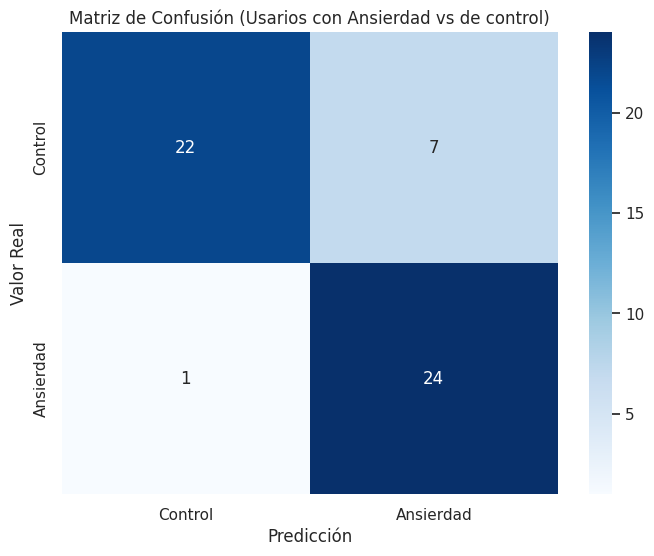

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Ansierdad'], yticklabels=['Control', 'Ansierdad'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Usarios con Ansierdad vs de control)')

# Mostrar la gráfica
plt.show()

# **Regresión Logistica**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
# Crear el modelo de regresión logística
lr_model = LogisticRegression(C=10)
lr_model.fit(X_train, y_train)

# Calcular el porcentaje de acierto en el conjunto de entrenamiento
accuracy_train = lr_model.score(X_train, y_train) * 100

# Calcular el porcentaje de acierto en el conjunto de validación
accuracy_val = lr_model.score(X_val, y_val) * 100

# Predicciones en el conjunto de entrenamiento y validación
y_train_pred = lr_model.predict(X_train)
y_val_pred = lr_model.predict(X_val)

# Calcular precisión en el conjunto de entrenamiento y validación
precision_train = precision_score(y_train, y_train_pred)* 100
precision_val = precision_score(y_val, y_val_pred)* 100

# Calcular exhaustividad (recall) en el conjunto de entrenamiento y validación
recall_train = recall_score(y_train, y_train_pred)* 100
recall_val = recall_score(y_val, y_val_pred)* 100

# Calcular puntuación F1 en el conjunto de entrenamiento y validación
f1_train = f1_score(y_train, y_train_pred)* 100
f1_val = f1_score(y_val, y_val_pred)* 100


In [ ]:
# Mostrar métricas de entrenamiento
print("Métricas de entrenamiento:")
print("Exactitud (entrenamiento): {:.2f}%".format(accuracy_train))
print("Precisión (entrenamiento): {:.2f}%".format(precision_train))
print("Exhaustividad (entrenamiento): {:.2f}%".format(recall_train))
print("Puntuación F1 (entrenamiento): {:.2f}%".format(f1_train))
print('-'*40)
# Mostrar métricas de validación
print("\nMétricas de validación:")
print("Exactitud (validación): {:.2f}%".format(accuracy_val))
print("Precisión (validación): {:.2f}%".format(precision_val))
print("Exhaustividad (validación): {:.2f}%".format(recall_val))
print("Puntuación F1 (validación): {:.2f}%".format(f1_val))

Métricas de entrenamiento:
Exactitud (entrenamiento): 88.10%
Precisión (entrenamiento): 83.78%
Exhaustividad (entrenamiento): 95.38%
Puntuación F1 (entrenamiento): 89.21%
----------------------------------------

Métricas de validación:
Exactitud (validación): 87.04%
Precisión (validación): 82.14%
Exhaustividad (validación): 92.00%
Puntuación F1 (validación): 86.79%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_RF = lr_model.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred_RF > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[24  5]
 [ 2 23]] 

Proporción de comentarios positivos: 0.46
Proporción de comentarios positivos etiquetados: 0.52


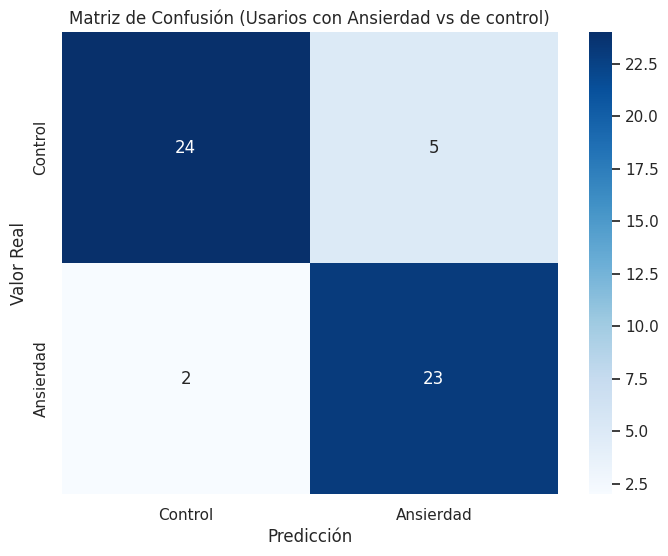

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Ansierdad'], yticklabels=['Control', 'Ansierdad'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Usarios con Ansierdad vs de control)')

# Mostrar la gráfica
plt.show()

# **Clasificación multiclases**

In [ ]:
# Lista de palabras
lista_palabras  = ["Preocupación", "Nerviosismo", "Estrés", "Incertidumbre", "Miedo", "Ansiedad", "Inquietud", "Pánico", "Temor", "Agobio","Tristeza", "Soledad", "Vacío", "Desánimo", "Desmotivación", "Desesperanza", "Aislamiento", "Melancolía", "Dolor", "Fatiga" ]

# Convertir la lista de palabras a un conjunto para eliminar duplicados
vocabulario = set(lista_palabras)

# Ruta del archivo para guardar el vocabulario
vocab_filename = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/vocab_C.txt'

# Guardar el vocabulario en el archivo
with open(vocab_filename, 'w') as file:
    for palabra in vocabulario:
        file.write(f"{palabra}\n")

# Imprimir el vocabulario
print("Vocabulario creado y guardado en el archivo:")
print(vocabulario)


Vocabulario creado y guardado en el archivo:
{'Incertidumbre', 'Tristeza', 'Dolor', 'Miedo', 'Soledad', 'Vacío', 'Melancolía', 'Desmotivación', 'Temor', 'Preocupación', 'Ansiedad', 'Aislamiento', 'Nerviosismo', 'Desánimo', 'Fatiga', 'Pánico', 'Inquietud', 'Desesperanza', 'Estrés', 'Agobio'}


In [ ]:
def load_clean_dataset(vocab, is_train):
  Ans = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuarios con ansiedad/', vocab, is_train)
  Cont = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuario de control/', vocab, is_train)
  Dep = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuarios con depresión/', vocab, is_train)
  docs = Ans + Cont +Dep
  labels = np.array([1 for _ in range(len(Ans))] + [2 for _ in range(len(Dep))] + [0 for _ in range(len(Cont))])
  return docs, labels

In [ ]:
# Cargar los datos limpios (entrenamiento y prueba)
vocab_filename = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/vocab_C.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

train_docs, y = load_clean_dataset(vocab, True)
test_docs, y_test = load_clean_dataset(vocab, False)

tokenizer = create_tokenizer(train_docs)
x = tokenizer.texts_to_matrix(train_docs, mode='binary')
# x_test = tokenizer.texts_to_matrix(test_docs, mode='binary')

# n_words = x_test.shape[1]

# Dividir los datos en conjuntos de entrenamiento (70%) y validación (30%)
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)


In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(189, 683)
(81, 683)
(189,)
(81,)


In [ ]:
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
# Crear una red neuronal secuencial
model = Sequential()

# Agregar una capa de entrada con el número de características (vocabulario) en tu matriz TF-IDF
model.add(Dense(328, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa oculta
model.add(Dense(164, activation='relu'))
model.add(Dropout(0.1))  # Dropout para regularización
# Convertir las etiquetas en codificación one-hot
num_classes = 3  # Número de clases
y_train_one_hot = to_categorical(y_train, num_classes)
y_val_one_hot = to_categorical(y_val, num_classes)

# Crear una red neuronal secuencial
model = Sequential()

# Agregar una capa de entrada con el número de características en X_train
model.add(Dense(328, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa oculta
model.add(Dense(164, activation='relu'))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa de salida con el número de clases en tu clasificación multiclase
model.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy()])

# Entrenar el modelo en los datos de entrenamiento
history = model.fit(X_train, y_train_one_hot, epochs=30, batch_size=20, validation_data=(X_val, y_val_one_hot))

y_val_pred = model.predict(X_val)

y_val_pred_class = y_val_pred.argmax(axis=1)  # Obtener la clase con la mayor probabilidad
y_val_true_class = y_val_one_hot.argmax(axis=1)  # Usar y_val_one_hot en lugar de y_val si está codificado en one-hot

accuracy = accuracy_score(y_val_true_class, y_val_pred_class)
precision = precision_score(y_val_true_class, y_val_pred_class, average='macro')
recall = recall_score(y_val_true_class, y_val_pred_class, average='macro')
f1 = f1_score(y_val_true_class, y_val_pred_class, average='macro')

y_train_pred = model.predict(X_train)

# Calcular métricas de evaluación en el conjunto de entrenamiento
y_train_pred_class = y_train_pred.argmax(axis=1)  # Obtener la clase con la mayor probabilidad
y_train_true_class = y_train_one_hot.argmax(axis=1)  # Usar y_train_one_hot en lugar de y_train si está codificado en one-hot

accuracy_train = accuracy_score(y_train_true_class, y_train_pred_class)
precision_train = precision_score(y_train_true_class, y_train_pred_class, average='macro')
recall_train = recall_score(y_train_true_class, y_train_pred_class, average='macro')
f1_train = f1_score(y_train_true_class, y_train_pred_class, average='macro')

Epoch 1/30
10/10 [==============================] - 1s 31ms/step - loss: 1.0828 - categorical_accuracy: 0.4233 - val_loss: 1.0372 - val_categorical_accuracy: 0.3827
Epoch 2/30
10/10 [==============================] - 0s 11ms/step - loss: 0.9405 - categorical_accuracy: 0.5661 - val_loss: 0.9844 - val_categorical_accuracy: 0.5062
Epoch 3/30
10/10 [==============================] - 0s 10ms/step - loss: 0.8562 - categorical_accuracy: 0.6190 - val_loss: 0.9095 - val_categorical_accuracy: 0.5185
Epoch 4/30
10/10 [==============================] - 0s 11ms/step - loss: 0.7759 - categorical_accuracy: 0.6296 - val_loss: 0.8899 - val_categorical_accuracy: 0.5432
Epoch 5/30
10/10 [==============================] - 0s 11ms/step - loss: 0.7193 - categorical_accuracy: 0.6825 - val_loss: 0.8908 - val_categorical_accuracy: 0.5309
Epoch 6/30
10/10 [==============================] - 0s 15ms/step - loss: 0.6756 - categorical_accuracy: 0.6720 - val_loss: 0.9461 - val_categorical_accuracy: 0.5679
Epoch 7/30

In [ ]:
# Imprimir métricas de entrenamiento
print("\nMétricas en el conjunto de entrenamiento:")
print(f"Exactitud (entrenamiento): {round(accuracy_train, 2) * 100}%")
print(f"Precisión (entrenamiento): {round(precision_train, 2) * 100}%")
print(f"Recall (entrenamiento): {round(recall_train, 2) * 100}%")
print(f"F1-score (entrenamiento): {round(f1_train, 2) * 100}%")
print('-------------------------------------------------------------------------')
# Imprimir métricas de evaluación
print(f"Exactitud en el conjunto de validación: {round(accuracy, 2) * 100}%")
print(f"Precisión en el conjunto de validación: {round(precision, 2) * 100}%")
print(f"Recall en el conjunto de validación: {round(recall, 2) * 100}%")
print(f"F1-score en el conjunto de validación: {round(f1, 2) * 100}%")


Métricas en el conjunto de entrenamiento:
Exactitud (entrenamiento): 76.0%
Precisión (entrenamiento): 83.0%
Recall (entrenamiento): 76.0%
F1-score (entrenamiento): 76.0%
-------------------------------------------------------------------------
Exactitud en el conjunto de validación: 54.0%
Precisión en el conjunto de validación: 55.00000000000001%
Recall en el conjunto de validación: 54.0%
F1-score en el conjunto de validación: 52.0%


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_true_class, y_train_pred_class)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(cm)

Matriz de Confusión:
[[33 29  0]
 [ 1 59  2]
 [ 2 11 52]]


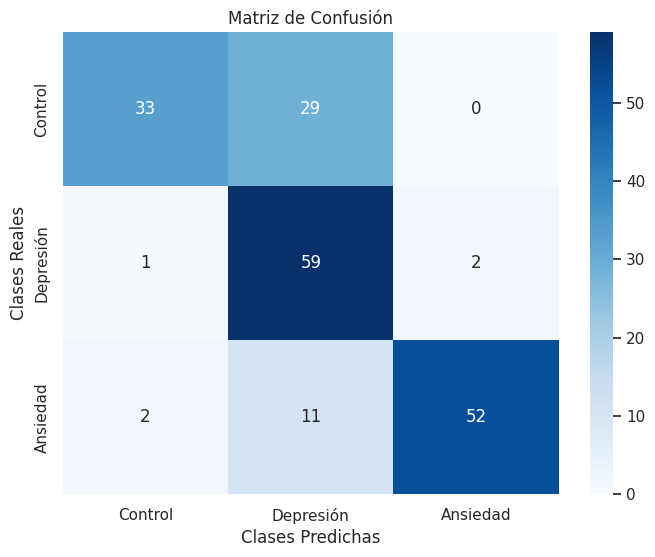

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir etiquetas de las clases
classes = ['Control', 'Depresión', 'Ansiedad']

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Agregar etiquetas y título
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.title('Matriz de Confusión')

plt.show()

#Modelo Arbol Aleatorio

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Crea un modelo de Random Forest
random_forest_model = RandomForestClassifier(
    n_estimators=300,  # Número de árboles
    max_depth=100,  # Profundidad máxima de los árboles
    random_state=42,  # Semilla aleatoria para reproducibilidad
    n_jobs=-1  # Utilizar todos los núcleos de la CPU para procesamiento en paralelo
)

# Entrena el modelo con los datos de entrenamiento
random_forest_model.fit(X_train, y_train)

# Realiza predicciones en los datos de validación
y_val_pred = random_forest_model.predict(X_val)

# Calcula e imprime la precisión del modelo en los datos de validación
accuracy = accuracy_score(y_val, y_val_pred)
print("Precisión (Validación): {:.2f}".format(accuracy))

# Calcula e imprime la precisión del modelo en los datos de validación
precision = precision_score(y_val, y_val_pred, average='weighted')
print("Precisión (Validación): {:.2f}".format(precision))

# Calcula e imprime la exhaustividad del modelo en los datos de validación
recall = recall_score(y_val, y_val_pred, average='weighted')
print("Exhaustividad (Validación): {:.2f}".format(recall))

# Calcula e imprime la puntuación F1 del modelo en los datos de validación
f1 = f1_score(y_val, y_val_pred, average='weighted')
print("Puntuación F1 (Validación): {:.2f}".format(f1))

# Calcula e imprime métricas en el conjunto de entrenamiento
y_train_pred = random_forest_model.predict(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_train = f1_score(y_train, y_train_pred, average='weighted')

print("\nMétricas en el conjunto de entrenamiento:")
print("Precisión: {:.2f}".format(precision_train))
print("Exhaustividad: {:.2f}".format(recall_train))
print("Puntuación F1: {:.2f}".format(f1_train))

Precisión (Validación): 0.59
Precisión (Validación): 0.63
Exhaustividad (Validación): 0.59
Puntuación F1 (Validación): 0.56

Métricas en el conjunto de entrenamiento:
Precisión: 0.85
Exhaustividad: 0.77
Puntuación F1: 0.77


In [ ]:
# Imprimir las métricas de entrenamiento
print(f'Accuracy entrenamiento: {accuracy_train * 100:.2f}%')
print(f'Precisión  entrenamiento: {precision_train * 100:.2f}%')
print(f'Recall  entrenamiento: {recall_train * 100:.2f}%')
print(f'Puntuación F1  entrenamiento: {f1_train * 100:.2f}%')
print('\n')
# Imprimir las métricas de validación
print(f'Accuracy  validación: {accuracy * 100:.2f}%')
print(f'Precisión  validación: {precision* 100:.2f}%')
print(f'Recall  validación: {recall* 100:.2f}%')
print(f'Puntuación F1 validación: {f1 * 100:.2f}%')

Accuracy entrenamiento: 76.72%
Precisión  entrenamiento: 84.55%
Recall  entrenamiento: 76.72%
Puntuación F1  entrenamiento: 76.56%


Accuracy  validación: 59.26%
Precisión  validación: 63.05%
Recall  validación: 59.26%
Puntuación F1 validación: 55.62%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = random_forest_model.predict(X_val)

#
cm = confusion_matrix(y_val, y_pred)


#
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)
print("Matriz de confusión: \n\n", cm, "\n")

Matriz de confusión: 

 [[ 6 18  4]
 [ 2 26  0]
 [ 2  7 16]] 



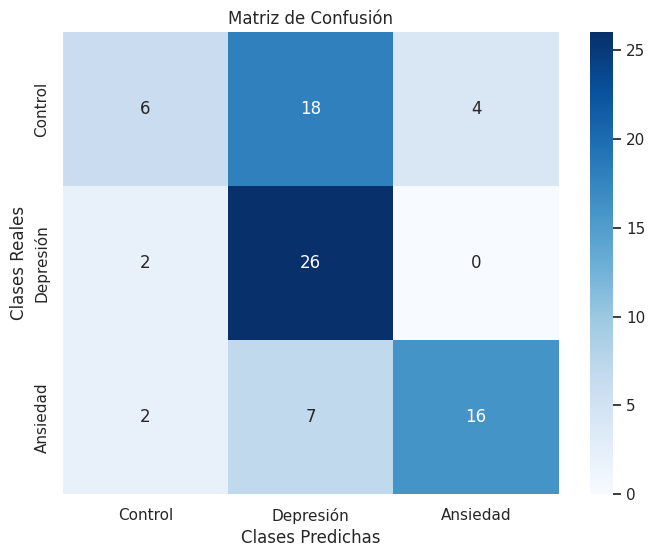

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir etiquetas de las clases
classes = ['Control', 'Depresión', 'Ansiedad']

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Agregar etiquetas y título
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.title('Matriz de Confusión')

plt.show()

#Modelo SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import os

# Suponiendo que ya tienes tus datos de entrenamiento y validación: X_train, X_val, y_train, y_val

# Crear un modelo SVM para clasificación multiclase con kernel polinómico
svm_model_p = SVC(kernel='linear', degree=4, C=100,max_iter=500000,  probability=False)

# Entrenar el modelo en los datos de entrenamiento
svm_model_p.fit(X_train, y_train)

# Predecir etiquetas en el conjunto de validación
y_val_pred = svm_model_p.predict(X_val)

# Calcular las métricas en el conjunto de validación
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='weighted')
recall = recall_score(y_val, y_val_pred, average='weighted')
f1 = f1_score(y_val, y_val_pred, average='weighted')

# Calcular y mostrar métricas en el conjunto de entrenamiento
y_train_pred = svm_model_p.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_train = f1_score(y_train, y_train_pred, average='weighted')

# Imprimir las métricas en el conjunto de entrenamiento
print("\nMétricas en el conjunto de entrenamiento:")
print("Exactitud (entrenamiento): {:.2%}".format(accuracy_train))
print("Precisión (entrenamiento): {:.2%}".format(precision_train))
print("Recall (entrenamiento): {:.2%}".format(recall_train))
print("F1-score (entrenamiento): {:.2%}".format(f1_train))
print('--'*50)
# Imprimir las métricas en el conjunto de validación
print("Exactitud en el conjunto de validación: {:.2%}".format(accuracy))
print("Precisión en el conjunto de validación: {:.2%}".format(precision))
print("Recall en el conjunto de validación: {:.2%}".format(recall))
print("F1-score en el conjunto de validación: {:.2%}".format(f1))



Métricas en el conjunto de entrenamiento:
Exactitud (entrenamiento): 76.72%
Precisión (entrenamiento): 82.96%
Recall (entrenamiento): 76.72%
F1-score (entrenamiento): 76.66%
----------------------------------------------------------------------------------------------------
Exactitud en el conjunto de validación: 55.56%
Precisión en el conjunto de validación: 58.20%
Recall en el conjunto de validación: 55.56%
F1-score en el conjunto de validación: 51.35%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = random_forest_model.predict(X_val)

#
cm = confusion_matrix(y_val, y_pred)


#
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)
print("Matriz de confusión: \n\n", cm, "\n")

Matriz de confusión: 

 [[ 6 18  4]
 [ 2 26  0]
 [ 2  7 16]] 



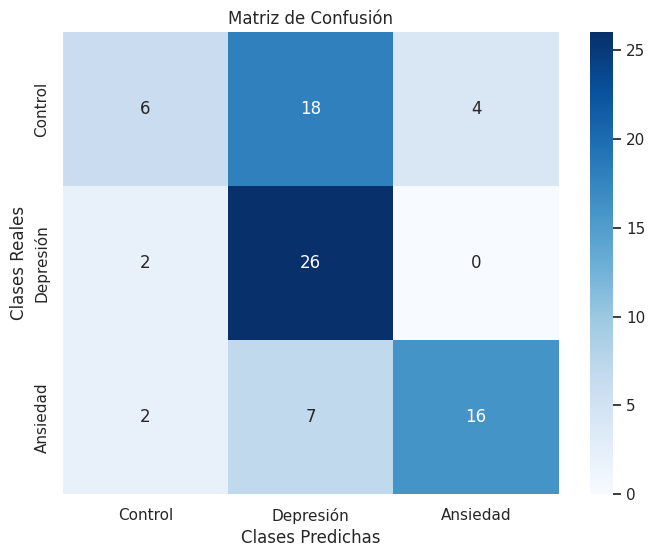

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir etiquetas de las clases
classes = ['Control', 'Depresión', 'Ansiedad']

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Agregar etiquetas y título
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.title('Matriz de Confusión')

plt.show()

**TFIDF**

In [ ]:
from keras.preprocessing.text import Tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [ ]:
def load_doc(filename):
    try:
        data = pd.read_csv(filename, delimiter=';')
        return data
    except Exception as e:
        print("Error:", e)
        return None

In [ ]:
def doc_to_line(filename, vocab):
  doc = load_doc(filename)
  tokens = clean(doc)
  tokens = [w for w in tokens if w in vocab]
  return ' '.join(tokens)

In [ ]:
def process_docs(directory, vocab, is_train):
    lines = list()
    for filename in os.listdir(directory):
        if is_train and filename.startswith('(72)'):
            continue  # Omitir archivos de prueba en el conjunto de entrenamiento
        if not is_train and not filename.startswith('(72)'):
            continue  # Omitir archivos de entrenamiento en el conjunto de prueba
        path = os.path.join(directory, filename)
        doc = load_doc(path)
        line = doc_to_line(doc, vocab)
        lines.append(line)
    return lines

# Depresión

In [ ]:
# Lista de palabras
lista_palabras = ["Tristeza", "Soledad", "Vacío", "Desánimo", "Desmotivación", "Desesperanza", "Aislamiento", "Melancolía", "Dolor", "Fatiga"]

# Convertir la lista de palabras a un conjunto para eliminar duplicados
vocabulario = set(lista_palabras)

# Ruta del archivo para guardar el vocabulario
vocab_filename = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/vocab_d.txt'

# Guardar el vocabulario en el archivo
with open(vocab_filename, 'w') as file:
    for palabra in vocabulario:
        file.write(f"{palabra}\n")

# Imprimir el vocabulario
print("Vocabulario creado y guardado en el archivo:")
print(vocabulario)


Vocabulario creado y guardado en el archivo:
{'Soledad', 'Desánimo', 'Vacío', 'Melancolía', 'Fatiga', 'Desmotivación', 'Tristeza', 'Desesperanza', 'Dolor', 'Aislamiento'}


In [ ]:
vocab_filename = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/vocab_d.txt'
with open(vocab_filename, 'r') as file:
    vocab_content = file.read()

vocab = vocab_content.split()
vocab = set(vocab)
print(vocab)

{'Soledad', 'Desánimo', 'Vacío', 'Melancolía', 'Fatiga', 'Desmotivación', 'Tristeza', 'Desesperanza', 'Dolor', 'Aislamiento'}


In [ ]:
import array
#Del mismo modo, la función load_clean_dataset() debe actualizarse para cargar el entrenamiento o prueba
# y asegúrarse de que devuelva una matriz Numpy
def load_clean_dataset(vocab, is_train):
  Dep = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuarios con depresión/', vocab, is_train)
  Cont = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuario de control/', vocab, is_train)
  docs = Dep + Cont
  labels = np.array([1 for _ in range(len(Dep))] + [0 for _ in range(len(Cont))])
  return docs, labels

In [ ]:
def process_docs(directory, vocab, is_train):
    lines = list()
    for filename in os.listdir(directory):
        path = os.path.join(directory, filename)
        if os.path.isfile(path):  # Verificar si es un archivo antes de procesarlo
            doc = load_doc(path)
            line = ' '.join(clean(doc))
            lines.append(line)
    return lines

def load_doc(filename):
    with open(filename, 'r') as file:
        text = file.read()
    return text

In [ ]:
import os
import joblib
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

vocab_filename = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/vocab_d.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

train_docs, y = load_clean_dataset(vocab, True)
test_docs, y_test = load_clean_dataset(vocab, False)

tokenizer = create_tokenizer(train_docs)
x = tokenizer.texts_to_matrix(train_docs, mode='tfidf')
x_test = tokenizer.texts_to_matrix(test_docs, mode='tfidf')


# Dividir los datos en conjuntos de entrenamiento (70%) y validación (30%)
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)


In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(126, 551)
(54, 551)
(126,)
(54,)


#**Red neuronal**

In [ ]:
# Crear una red neuronal secuencial
model = Sequential()

# Agregar una capa de entrada con el número de características (vocabulario) en tu matriz TF-IDF
model.add(Dense(328, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa oculta
model.add(Dense(164, activation='relu'))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa de salida con una neurona y función de activación sigmoide para clasificación binaria
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo en los datos de entrenamiento
history = model.fit(X_train, y_train, epochs=100, batch_size=50, validation_data=(X_val, y_val))

# Evaluar el modelo en el conjunto de validación
y_val_pred = (model.predict(X_val) > 0.5).astype(int)

# Calcular métricas de evaluación en el conjunto de validación
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Calcular métricas de evaluación en el conjunto de entrenamiento
y_train_pred = (model.predict(X_train) > 0.5).astype(int)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

Epoch 1/100
3/3 [==============================] - 1s 111ms/step - loss: 0.7966 - accuracy: 0.4365 - val_loss: 1.0589 - val_accuracy: 0.5185
Epoch 2/100
3/3 [==============================] - 0s 34ms/step - loss: 0.8616 - accuracy: 0.5794 - val_loss: 0.6278 - val_accuracy: 0.8148
Epoch 3/100
3/3 [==============================] - 0s 23ms/step - loss: 0.5749 - accuracy: 0.6508 - val_loss: 0.7420 - val_accuracy: 0.5556
Epoch 4/100
3/3 [==============================] - 0s 29ms/step - loss: 0.5236 - accuracy: 0.7143 - val_loss: 0.7121 - val_accuracy: 0.6667
Epoch 5/100
3/3 [==============================] - 0s 31ms/step - loss: 0.5211 - accuracy: 0.7063 - val_loss: 0.7670 - val_accuracy: 0.6667
Epoch 6/100
3/3 [==============================] - 0s 30ms/step - loss: 0.4596 - accuracy: 0.7619 - val_loss: 0.6991 - val_accuracy: 0.8519
Epoch 7/100
3/3 [==============================] - 0s 24ms/step - loss: 0.4471 - accuracy: 0.7460 - val_loss: 0.7092 - val_accuracy: 0.8148
Epoch 8/100
3/3 [==

In [ ]:
# Imprimir métricas de entrenamiento
print("\nMétricas en el conjunto de entrenamiento:")
print(f"Exactitud (entrenamiento): {round(accuracy_train, 2) * 100}%")
print(f"Precisión (entrenamiento): {round(precision_train, 2) * 100}%")
print(f"Recall (entrenamiento): {round(recall_train, 2) * 100}%")
print(f"F1-score (entrenamiento): {round(f1_train, 2) * 100}%")
print('-------------------------------------------------------------------------')
# Imprimir métricas de evaluación
print(f"Exactitud en el conjunto de validación: {round(accuracy, 2) * 100}%")
print(f"Precisión en el conjunto de validación: {round(precision, 2) * 100}%")
print(f"Recall en el conjunto de validación: {round(recall, 2) * 100}%")
print(f"F1-score en el conjunto de validación: {round(f1, 2) * 100}%")


Métricas en el conjunto de entrenamiento:
Exactitud (entrenamiento): 98.0%
Precisión (entrenamiento): 97.0%
Recall (entrenamiento): 100.0%
F1-score (entrenamiento): 98.0%
-------------------------------------------------------------------------
Exactitud en el conjunto de validación: 76.0%
Precisión en el conjunto de validación: 77.0%
Recall en el conjunto de validación: 68.0%
F1-score en el conjunto de validación: 72.0%


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

2/2 [==============================] - 0s 10ms/step
Matriz de confusión: 

 [[24  5]
 [ 8 17]] 

Proporción de comentarios positivos: 0.46
Proporción de comentarios positivos etiquetados: 0.41


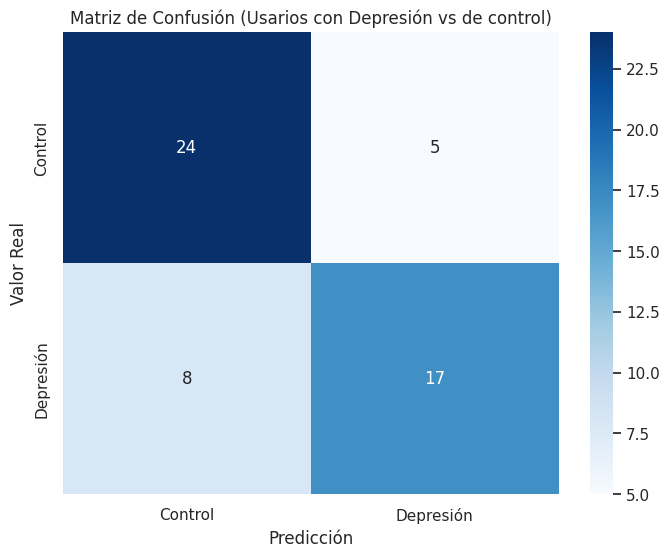

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Depresión'], yticklabels=['Control', 'Depresión'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Usarios con Depresión vs de control)')

# Mostrar la gráfica
plt.show()

#Modelo Arbol Aleatorio

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Importa las librerías necesarias y divide los datos en conjuntos de entrenamiento y validación
from sklearn.model_selection import train_test_split

# X_train, X_val, y_train, y_val

# Crea un modelo de Random Forest
random_forest_model = RandomForestClassifier(n_estimators=300,  # Numero de alboles
                                             max_depth=100, # profunidad máxima
                                             random_state=42)  # selección de la semilla de manera aleatoria


# Entrena el modelo en los datos de entrenamiento
random_forest_model.fit(X_train, y_train)

# Realiza predicciones en los datos de validación
y_val_pred = random_forest_model.predict(X_val)

# Calcula la precisión (accuracy) del modelo en los datos de validación
accuracy = accuracy_score(y_val, y_val_pred)
print("Accuracy (validación): {:.2f}".format(accuracy))

# Calcula la precisión del modelo en los datos de validación
precision = precision_score(y_val, y_val_pred)
print("Precision (validación): {:.2f}".format(precision))

# Calcula la exactitud (recall) del modelo en los datos de validación
recall = recall_score(y_val, y_val_pred)
print("Recall (validación): {:.2f}".format(recall))

# Calcula el F1-score del modelo en los datos de validación
f1 = f1_score(y_val, y_val_pred)
print("F1-score (validación): {:.2f}".format(f1))

# Calcula y muestra métricas en el conjunto de entrenamiento
y_train_pred = random_forest_model.predict(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

#




Accuracy (validación): 0.89
Precision (validación): 0.85
Recall (validación): 0.92
F1-score (validación): 0.88


In [ ]:
# Imprimir las métricas de entrenamiento
print(f'Accuracy entrenamiento: {accuracy_train * 100:.2f}%')
print(f'Precisión  entrenamiento: {precision_train * 100:.2f}%')
print(f'Recall  entrenamiento: {recall_train * 100:.2f}%')
print(f'Puntuación F1  entrenamiento: {f1_train * 100:.2f}%')
print('\n')
# Imprimir las métricas de validación
print(f'Accuracy  validación: {accuracy * 100:.2f}%')
print(f'Precisión  validación: {precision* 100:.2f}%')
print(f'Recall  validación: {recall* 100:.2f}%')
print(f'Puntuación F1 validación: {f1 * 100:.2f}%')

Accuracy entrenamiento: 100.00%
Precisión  entrenamiento: 100.00%
Recall  entrenamiento: 100.00%
Puntuación F1  entrenamiento: 100.00%


Accuracy  validación: 88.89%
Precisión  validación: 85.19%
Recall  validación: 92.00%
Puntuación F1 validación: 88.46%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_RF = random_forest_model.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred_RF > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[25  4]
 [ 2 23]] 

Proporción de comentarios positivos: 0.46
Proporción de comentarios positivos etiquetados: 0.50


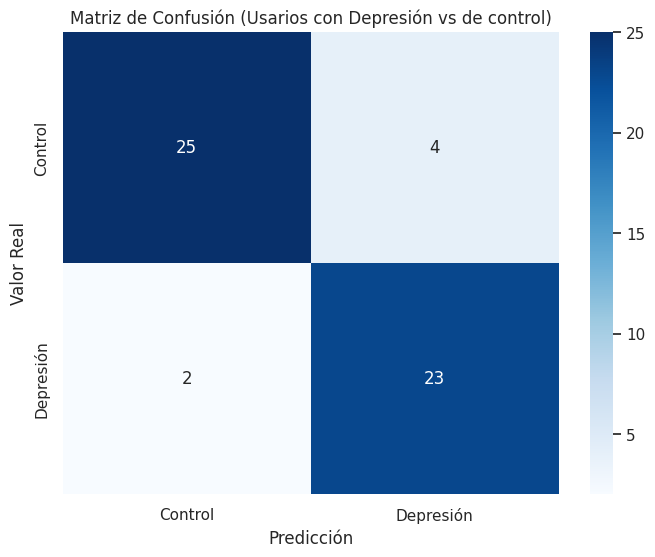

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Depresión'], yticklabels=['Control', 'Depresión'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Usarios con Depresión vs de control)')

# Mostrar la gráfica
plt.show()

#Modelo SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import os

svm_model_p = SVC(kernel='linear', degree=4, C=100, max_iter=100000, probability=False)

# Entrenar el modelo en los datos de entrenamiento
svm_model_p.fit(X_train, y_train)

# Predecir etiquetas en el conjunto de validación
y_val_pred = svm_model_p.predict(X_val)

# Calcula la precisión del modelo en el conjunto de validación
accuracy = accuracy_score(y_val, y_val_pred)


# Calcula precisión, exhaustividad y puntuación F1 en el conjunto de validación
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Calcula y muestra métricas en el conjunto de entrenamiento
y_train_pred = svm_model_p.predict(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

print("\nEntrenamiento:")
print("Exactitud (entrenamiento): {:.2f}%".format(accuracy_train*100))
print("Precision (entrenamiento): {:.2f}%".format(precision_train*100))
print("Recall (entrenamiento): {:.2f}%".format(recall_train*100))
print("F1-score (entrenamiento): {:.2f}%".format(f1_train*100))
print("\nValidación:")
print(f"Exactitud en el conjunto de validación: {round(accuracy,2)*100}%")
print(f"Precisión en el conjunto de validación:{round(precision,2)*100}%")
print(f"Recall en el conjunto de validación: {round(recall,2)*100}%")
print(f"F1-score en el conjunto de validación:{round(f1,2)*100}%")




Entrenamiento:
Exactitud (entrenamiento): 100.00%
Precision (entrenamiento): 100.00%
Recall (entrenamiento): 100.00%
F1-score (entrenamiento): 100.00%

Validación:
Exactitud en el conjunto de validación: 93.0%
Precisión en el conjunto de validación:92.0%
Recall en el conjunto de validación: 92.0%
F1-score en el conjunto de validación:92.0%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_RF = svm_model_p.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred_RF > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[27  2]
 [ 2 23]] 

Proporción de comentarios positivos: 0.46
Proporción de comentarios positivos etiquetados: 0.46


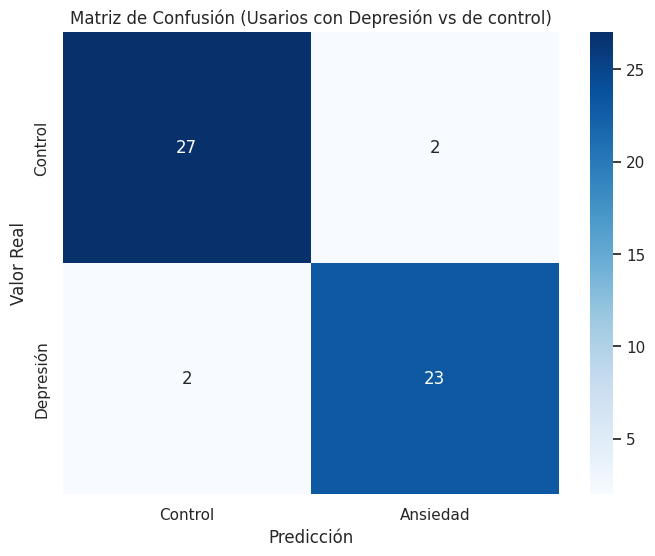

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Ansiedad'], yticklabels=['Control', 'Depresión'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Usarios con Depresión vs de control)')

# Mostrar la gráfica
plt.show()

# **Regresión Logistica**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
# Crear el modelo de regresión logística
lr_model = LogisticRegression(C=10)
lr_model.fit(X_train, y_train)

# Calcular el porcentaje de acierto en el conjunto de entrenamiento
accuracy_train = lr_model.score(X_train, y_train) * 100

# Calcular el porcentaje de acierto en el conjunto de validación
accuracy_val = lr_model.score(X_val, y_val) * 100

# Predicciones en el conjunto de entrenamiento y validación
y_train_pred = lr_model.predict(X_train)
y_val_pred = lr_model.predict(X_val)

# Calcular precisión en el conjunto de entrenamiento y validación
precision_train = precision_score(y_train, y_train_pred)* 100
precision_val = precision_score(y_val, y_val_pred)* 100

# Calcular exhaustividad (recall) en el conjunto de entrenamiento y validación
recall_train = recall_score(y_train, y_train_pred)* 100
recall_val = recall_score(y_val, y_val_pred)* 100

# Calcular puntuación F1 en el conjunto de entrenamiento y validación
f1_train = f1_score(y_train, y_train_pred)* 100
f1_val = f1_score(y_val, y_val_pred)* 100


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Mostrar métricas de entrenamiento
print("Métricas de entrenamiento:")
print("Exactitud (entrenamiento): {:.2f}%".format(accuracy_train))
print("Precisión (entrenamiento): {:.2f}%".format(precision_train))
print("Exhaustividad (entrenamiento): {:.2f}%".format(recall_train))
print("Puntuación F1 (entrenamiento): {:.2f}%".format(f1_train))
print('-'*40)
# Mostrar métricas de validación
print("\nMétricas de validación:")
print("Exactitud (validación): {:.2f}%".format(accuracy_val))
print("Precisión (validación): {:.2f}%".format(precision_val))
print("Exhaustividad (validación): {:.2f}%".format(recall_val))
print("Puntuación F1 (validación): {:.2f}%".format(f1_val))

Métricas de entrenamiento:
Exactitud (entrenamiento): 100.00%
Precisión (entrenamiento): 100.00%
Exhaustividad (entrenamiento): 100.00%
Puntuación F1 (entrenamiento): 100.00%
----------------------------------------

Métricas de validación:
Exactitud (validación): 90.74%
Precisión (validación): 88.46%
Exhaustividad (validación): 92.00%
Puntuación F1 (validación): 90.20%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_RF = lr_model.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred_RF > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[26  3]
 [ 2 23]] 

Proporción de comentarios positivos: 0.46
Proporción de comentarios positivos etiquetados: 0.48


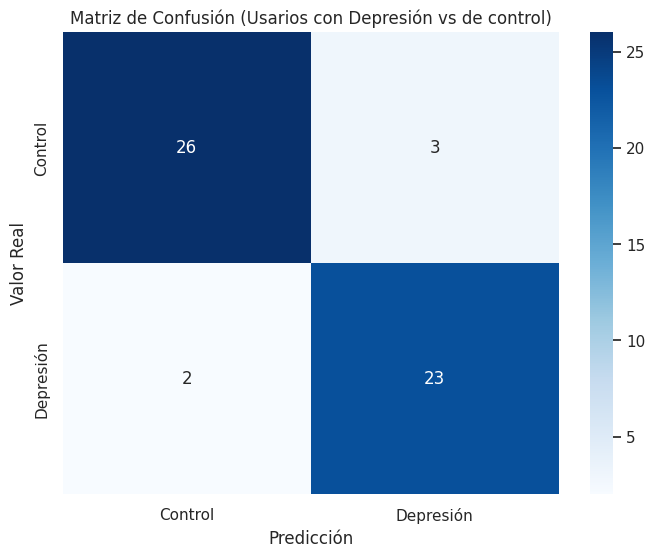

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Depresión'], yticklabels=['Control', 'Depresión'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Usarios con Depresión vs de control)')

# Mostrar la gráfica
plt.show()

In [ ]:
# Lista de palabras
lista_palabras  = ["Preocupación", "Nerviosismo", "Estrés", "Incertidumbre", "Miedo", "Ansiedad", "Inquietud", "Pánico", "Temor", "Agobio"]

# Convertir la lista de palabras a un conjunto para eliminar duplicados
vocabulario = set(lista_palabras)

# Ruta del archivo para guardar el vocabulario
vocab_filename = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/vocab_A.txt'

# Guardar el vocabulario en el archivo
with open(vocab_filename, 'w') as file:
    for palabra in vocabulario:
        file.write(f"{palabra}\n")

# Imprimir el vocabulario
print("Vocabulario creado y guardado en el archivo:")
print(vocabulario)


Vocabulario creado y guardado en el archivo:
{'Preocupación', 'Incertidumbre', 'Pánico', 'Inquietud', 'Ansiedad', 'Temor', 'Estrés', 'Agobio', 'Nerviosismo', 'Miedo'}


In [ ]:
vocab_filename = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/vocab_A.txt'
with open(vocab_filename, 'r') as file:
    vocab_content = file.read()

vocab = vocab_content.split()
vocab = set(vocab)
print(vocab)

{'Preocupación', 'Incertidumbre', 'Pánico', 'Inquietud', 'Ansiedad', 'Temor', 'Estrés', 'Agobio', 'Nerviosismo', 'Miedo'}


In [ ]:
import array
#Del mismo modo, la función load_clean_dataset() debe actualizarse para cargar el entrenamiento o prueba
# y asegúrarse de que devuelva una matriz Numpy
def load_clean_dataset(vocab, is_train):
  Dep = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuarios con ansiedad/', vocab, is_train)
  Cont = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuario de control/', vocab, is_train)
  docs = Dep + Cont
  labels = np.array([1 for _ in range(len(Dep))] + [0 for _ in range(len(Cont))])
  return docs, labels

In [ ]:
def process_docs(directory, vocab, is_train):
    lines = list()
    for filename in os.listdir(directory):
        path = os.path.join(directory, filename)
        if os.path.isfile(path):  # Verificar si es un archivo antes de procesarlo
            doc = load_doc(path)
            line = ' '.join(clean(doc))
            lines.append(line)
    return lines

def load_doc(filename):
    with open(filename, 'r') as file:
        text = file.read()
    return text

In [ ]:
import os
import joblib
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

vocab_filename = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/vocab_A.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

train_docs, y = load_clean_dataset(vocab, True)
test_docs, y_test = load_clean_dataset(vocab, False)

tokenizer = create_tokenizer(train_docs)
x = tokenizer.texts_to_matrix(train_docs, mode='tfidf')
x_test = tokenizer.texts_to_matrix(test_docs, mode='tfidf')


# Dividir los datos en conjuntos de entrenamiento (70%) y validación (30%)
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)


In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(126, 569)
(54, 569)
(126,)
(54,)


#**Red neuronal**

In [ ]:
# Crear una red neuronal secuencial
model = Sequential()

# Agregar una capa de entrada con el número de características (vocabulario) en tu matriz TF-IDF
model.add(Dense(328, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa oculta
model.add(Dense(164, activation='relu'))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa de salida con una neurona y función de activación sigmoide para clasificación binaria
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo en los datos de entrenamiento
history = model.fit(X_train, y_train, epochs=100, batch_size=50, validation_data=(X_val, y_val))

# Evaluar el modelo en el conjunto de validación
y_val_pred = (model.predict(X_val) > 0.5).astype(int)

# Calcular métricas de evaluación en el conjunto de validación
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Calcular métricas de evaluación en el conjunto de entrenamiento
y_train_pred = (model.predict(X_train) > 0.5).astype(int)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

Epoch 1/100
3/3 [==============================] - 1s 121ms/step - loss: 0.7508 - accuracy: 0.6111 - val_loss: 0.6171 - val_accuracy: 0.5556
Epoch 2/100
3/3 [==============================] - 0s 23ms/step - loss: 0.6441 - accuracy: 0.5794 - val_loss: 0.4581 - val_accuracy: 0.8333
Epoch 3/100
3/3 [==============================] - 0s 24ms/step - loss: 0.4950 - accuracy: 0.7778 - val_loss: 0.3956 - val_accuracy: 0.8519
Epoch 4/100
3/3 [==============================] - 0s 22ms/step - loss: 0.4142 - accuracy: 0.8492 - val_loss: 0.3675 - val_accuracy: 0.9630
Epoch 5/100
3/3 [==============================] - 0s 22ms/step - loss: 0.3766 - accuracy: 0.8571 - val_loss: 0.3639 - val_accuracy: 0.8148
Epoch 6/100
3/3 [==============================] - 0s 30ms/step - loss: 0.3994 - accuracy: 0.8095 - val_loss: 0.2794 - val_accuracy: 0.8889
Epoch 7/100
3/3 [==============================] - 0s 29ms/step - loss: 0.3682 - accuracy: 0.8413 - val_loss: 0.2666 - val_accuracy: 0.9444
Epoch 8/100
3/3 [==

In [ ]:
# Imprimir métricas de entrenamiento
print("\nMétricas en el conjunto de entrenamiento:")
print(f"Exactitud (entrenamiento): {round(accuracy_train, 2) * 100}%")
print(f"Precisión (entrenamiento): {round(precision_train, 2) * 100}%")
print(f"Recall (entrenamiento): {round(recall_train, 2) * 100}%")
print(f"F1-score (entrenamiento): {round(f1_train, 2) * 100}%")
print('-------------------------------------------------------------------------')
# Imprimir métricas de evaluación
print(f"Exactitud en el conjunto de validación: {round(accuracy, 2) * 100}%")
print(f"Precisión en el conjunto de validación: {round(precision, 2) * 100}%")
print(f"Recall en el conjunto de validación: {round(recall, 2) * 100}%")
print(f"F1-score en el conjunto de validación: {round(f1, 2) * 100}%")


Métricas en el conjunto de entrenamiento:
Exactitud (entrenamiento): 100.0%
Precisión (entrenamiento): 100.0%
Recall (entrenamiento): 100.0%
F1-score (entrenamiento): 100.0%
-------------------------------------------------------------------------
Exactitud en el conjunto de validación: 98.0%
Precisión en el conjunto de validación: 100.0%
Recall en el conjunto de validación: 96.0%
F1-score en el conjunto de validación: 98.0%


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

2/2 [==============================] - 0s 6ms/step
Matriz de confusión: 

 [[29  0]
 [ 1 24]] 

Proporción de comentarios positivos: 0.46
Proporción de comentarios positivos etiquetados: 0.44


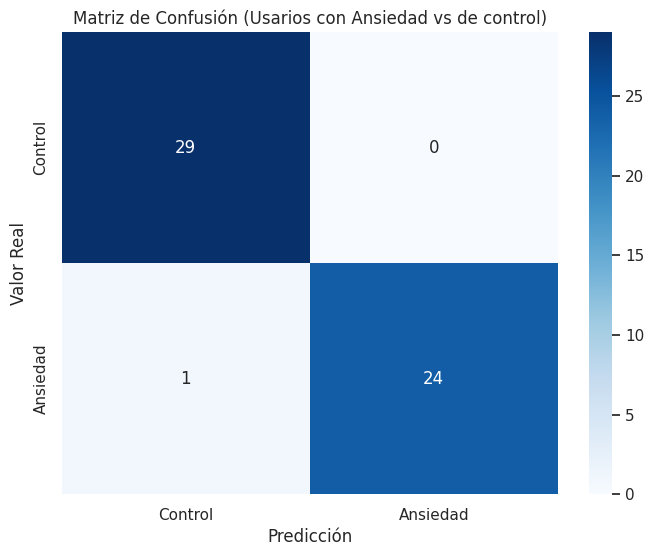

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Ansiedad'], yticklabels=['Control', 'Ansiedad'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Usarios con Ansiedad vs de control)')

# Mostrar la gráfica
plt.show()

#Modelo Arbol Aleatorio

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Importa las librerías necesarias y divide los datos en conjuntos de entrenamiento y validación
from sklearn.model_selection import train_test_split

# X_train, X_val, y_train, y_val

# Crea un modelo de Random Forest
random_forest_model = RandomForestClassifier(n_estimators=300,  # Numero de alboles
                                             max_depth=100, # profunidad máxima
                                             random_state=42)  # selección de la semilla de manera aleatoria


# Entrena el modelo en los datos de entrenamiento
random_forest_model.fit(X_train, y_train)

# Realiza predicciones en los datos de validación
y_val_pred = random_forest_model.predict(X_val)

# Calcula la precisión (accuracy) del modelo en los datos de validación
accuracy = accuracy_score(y_val, y_val_pred)
print("Accuracy (validación): {:.2f}".format(accuracy))

# Calcula la precisión del modelo en los datos de validación
precision = precision_score(y_val, y_val_pred)
print("Precision (validación): {:.2f}".format(precision))

# Calcula la exactitud (recall) del modelo en los datos de validación
recall = recall_score(y_val, y_val_pred)
print("Recall (validación): {:.2f}".format(recall))

# Calcula el F1-score del modelo en los datos de validación
f1 = f1_score(y_val, y_val_pred)
print("F1-score (validación): {:.2f}".format(f1))

# Calcula y muestra métricas en el conjunto de entrenamiento
y_train_pred = random_forest_model.predict(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

#




Accuracy (validación): 0.98
Precision (validación): 0.96
Recall (validación): 1.00
F1-score (validación): 0.98


In [ ]:
# Imprimir las métricas de entrenamiento
print(f'Accuracy entrenamiento: {accuracy_train * 100:.2f}%')
print(f'Precisión  entrenamiento: {precision_train * 100:.2f}%')
print(f'Recall  entrenamiento: {recall_train * 100:.2f}%')
print(f'Puntuación F1  entrenamiento: {f1_train * 100:.2f}%')
print('\n')
# Imprimir las métricas de validación
print(f'Accuracy  validación: {accuracy * 100:.2f}%')
print(f'Precisión  validación: {precision* 100:.2f}%')
print(f'Recall  validación: {recall* 100:.2f}%')
print(f'Puntuación F1 validación: {f1 * 100:.2f}%')

Accuracy entrenamiento: 100.00%
Precisión  entrenamiento: 100.00%
Recall  entrenamiento: 100.00%
Puntuación F1  entrenamiento: 100.00%


Accuracy  validación: 98.15%
Precisión  validación: 96.15%
Recall  validación: 100.00%
Puntuación F1 validación: 98.04%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_RF = random_forest_model.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred_RF > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[28  1]
 [ 0 25]] 

Proporción de comentarios positivos: 0.46
Proporción de comentarios positivos etiquetados: 0.48


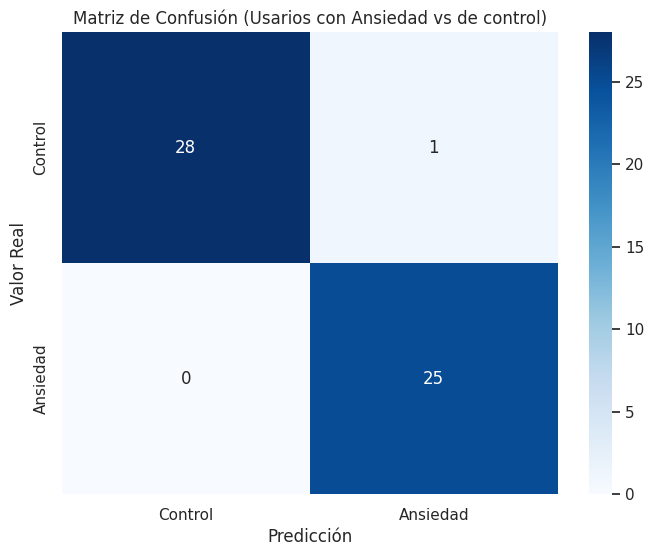

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Ansiedad'], yticklabels=['Control', 'Ansiedad'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Usarios con Ansiedad vs de control)')

# Mostrar la gráfica
plt.show()

#Modelo SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import os

svm_model_p = SVC(kernel='linear', degree=4, C=100, max_iter=100000, probability=False)

# Entrenar el modelo en los datos de entrenamiento
svm_model_p.fit(X_train, y_train)

# Predecir etiquetas en el conjunto de validación
y_val_pred = svm_model_p.predict(X_val)

# Calcula la precisión del modelo en el conjunto de validación
accuracy = accuracy_score(y_val, y_val_pred)


# Calcula precisión, exhaustividad y puntuación F1 en el conjunto de validación
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Calcula y muestra métricas en el conjunto de entrenamiento
y_train_pred = svm_model_p.predict(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

print("\nEntrenamiento:")
print("Exactitud (entrenamiento): {:.2f}%".format(accuracy_train*100))
print("Precision (entrenamiento): {:.2f}%".format(precision_train*100))
print("Recall (entrenamiento): {:.2f}%".format(recall_train*100))
print("F1-score (entrenamiento): {:.2f}%".format(f1_train*100))
print("\nValidación:")
print(f"Exactitud en el conjunto de validación: {round(accuracy,2)*100}%")
print(f"Precisión en el conjunto de validación:{round(precision,2)*100}%")
print(f"Recall en el conjunto de validación: {round(recall,2)*100}%")
print(f"F1-score en el conjunto de validación:{round(f1,2)*100}%")




Entrenamiento:
Exactitud (entrenamiento): 100.00%
Precision (entrenamiento): 100.00%
Recall (entrenamiento): 100.00%
F1-score (entrenamiento): 100.00%

Validación:
Exactitud en el conjunto de validación: 100.0%
Precisión en el conjunto de validación:100.0%
Recall en el conjunto de validación: 100.0%
F1-score en el conjunto de validación:100.0%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_RF = svm_model_p.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred_RF > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[29  0]
 [ 0 25]] 

Proporción de comentarios positivos: 0.46
Proporción de comentarios positivos etiquetados: 0.46


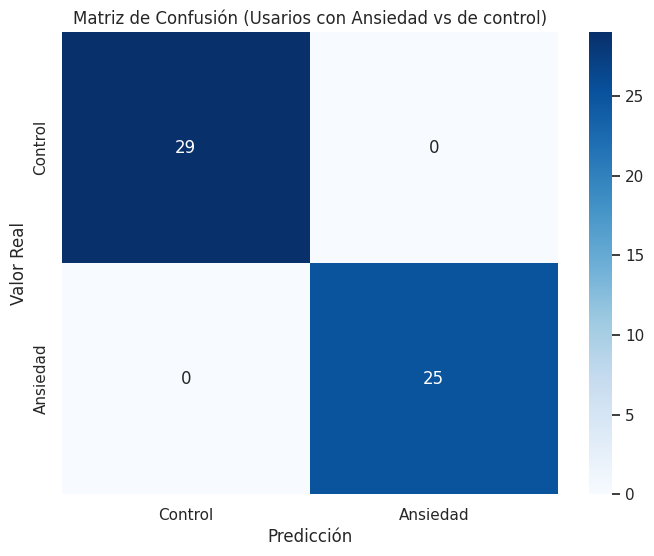

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Ansiedad'], yticklabels=['Control', 'Ansiedad'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Usarios con Ansiedad vs de control)')

# Mostrar la gráfica
plt.show()

# **Regresión Logistica**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
# Crear el modelo de regresión logística
lr_model = LogisticRegression(C=10)
lr_model.fit(X_train, y_train)

# Calcular el porcentaje de acierto en el conjunto de entrenamiento
accuracy_train = lr_model.score(X_train, y_train) * 100

# Calcular el porcentaje de acierto en el conjunto de validación
accuracy_val = lr_model.score(X_val, y_val) * 100

# Predicciones en el conjunto de entrenamiento y validación
y_train_pred = lr_model.predict(X_train)
y_val_pred = lr_model.predict(X_val)

# Calcular precisión en el conjunto de entrenamiento y validación
precision_train = precision_score(y_train, y_train_pred)* 100
precision_val = precision_score(y_val, y_val_pred)* 100

# Calcular exhaustividad (recall) en el conjunto de entrenamiento y validación
recall_train = recall_score(y_train, y_train_pred)* 100
recall_val = recall_score(y_val, y_val_pred)* 100

# Calcular puntuación F1 en el conjunto de entrenamiento y validación
f1_train = f1_score(y_train, y_train_pred)* 100
f1_val = f1_score(y_val, y_val_pred)* 100


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Mostrar métricas de entrenamiento
print("Métricas de entrenamiento:")
print("Exactitud (entrenamiento): {:.2f}%".format(accuracy_train))
print("Precisión (entrenamiento): {:.2f}%".format(precision_train))
print("Exhaustividad (entrenamiento): {:.2f}%".format(recall_train))
print("Puntuación F1 (entrenamiento): {:.2f}%".format(f1_train))
print('-'*40)
# Mostrar métricas de validación
print("\nMétricas de validación:")
print("Exactitud (validación): {:.2f}%".format(accuracy_val))
print("Precisión (validación): {:.2f}%".format(precision_val))
print("Exhaustividad (validación): {:.2f}%".format(recall_val))
print("Puntuación F1 (validación): {:.2f}%".format(f1_val))

Métricas de entrenamiento:
Exactitud (entrenamiento): 100.00%
Precisión (entrenamiento): 100.00%
Exhaustividad (entrenamiento): 100.00%
Puntuación F1 (entrenamiento): 100.00%
----------------------------------------

Métricas de validación:
Exactitud (validación): 100.00%
Precisión (validación): 100.00%
Exhaustividad (validación): 100.00%
Puntuación F1 (validación): 100.00%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_RF = lr_model.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred_RF > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[29  0]
 [ 0 25]] 

Proporción de comentarios positivos: 0.46
Proporción de comentarios positivos etiquetados: 0.46


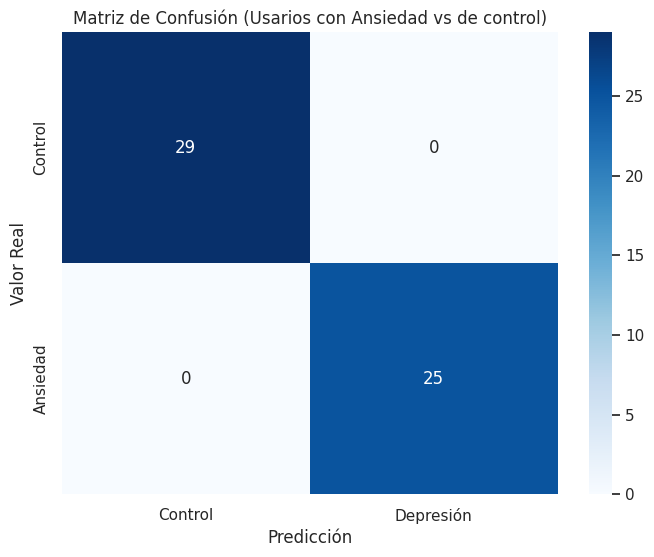

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Depresión'], yticklabels=['Control', 'Ansiedad'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Usarios con Ansiedad vs de control)')

# Mostrar la gráfica
plt.show()

# **Clasificación multiclases**

In [ ]:
# Lista de palabras
lista_palabras  = ["Preocupación", "Nerviosismo", "Estrés", "Incertidumbre", "Miedo", "Ansiedad", "Inquietud", "Pánico", "Temor", "Agobio","Tristeza", "Soledad", "Vacío", "Desánimo", "Desmotivación", "Desesperanza", "Aislamiento", "Melancolía", "Dolor", "Fatiga" ]

# Convertir la lista de palabras a un conjunto para eliminar duplicados
vocabulario = set(lista_palabras)

# Ruta del archivo para guardar el vocabulario
vocab_filename = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/vocab_C.txt'

# Guardar el vocabulario en el archivo
with open(vocab_filename, 'w') as file:
    for palabra in vocabulario:
        file.write(f"{palabra}\n")

# Imprimir el vocabulario
print("Vocabulario creado y guardado en el archivo:")
print(vocabulario)


Vocabulario creado y guardado en el archivo:
{'Incertidumbre', 'Tristeza', 'Dolor', 'Miedo', 'Soledad', 'Vacío', 'Melancolía', 'Desmotivación', 'Temor', 'Preocupación', 'Ansiedad', 'Aislamiento', 'Nerviosismo', 'Desánimo', 'Fatiga', 'Pánico', 'Inquietud', 'Desesperanza', 'Estrés', 'Agobio'}


In [ ]:
def load_clean_dataset(vocab, is_train):
  Ans = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuarios con ansiedad/', vocab, is_train)
  Cont = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuario de control/', vocab, is_train)
  Dep = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuarios con depresión/', vocab, is_train)
  docs = Ans + Cont +Dep
  labels = np.array([1 for _ in range(len(Ans))] + [2 for _ in range(len(Dep))] + [0 for _ in range(len(Cont))])
  return docs, labels

In [ ]:
# Cargar los datos limpios (entrenamiento y prueba)
vocab_filename = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/vocab_C.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

train_docs, y = load_clean_dataset(vocab, True)
test_docs, y_test = load_clean_dataset(vocab, False)

tokenizer = create_tokenizer(train_docs)
x = tokenizer.texts_to_matrix(train_docs, mode='tfidf')
# x_test = tokenizer.texts_to_matrix(test_docs, mode='binary')

# n_words = x_test.shape[1]

# Dividir los datos en conjuntos de entrenamiento (70%) y validación (30%)
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)


In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(189, 683)
(81, 683)
(189,)
(81,)


In [ ]:
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
# Crear una red neuronal secuencial
model = Sequential()

# Agregar una capa de entrada con el número de características (vocabulario) en tu matriz TF-IDF
model.add(Dense(328, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa oculta
model.add(Dense(164, activation='relu'))
model.add(Dropout(0.1))  # Dropout para regularización
# Convertir las etiquetas en codificación one-hot
num_classes = 3  # Número de clases
y_train_one_hot = to_categorical(y_train, num_classes)
y_val_one_hot = to_categorical(y_val, num_classes)

# Crear una red neuronal secuencial
model = Sequential()

# Agregar una capa de entrada con el número de características en X_train
model.add(Dense(328, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa oculta
model.add(Dense(164, activation='relu'))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa de salida con el número de clases en tu clasificación multiclase
model.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy()])

# Entrenar el modelo en los datos de entrenamiento
history = model.fit(X_train, y_train_one_hot, epochs=30, batch_size=20, validation_data=(X_val, y_val_one_hot))

y_val_pred = model.predict(X_val)

y_val_pred_class = y_val_pred.argmax(axis=1)  # Obtener la clase con la mayor probabilidad
y_val_true_class = y_val_one_hot.argmax(axis=1)  # Usar y_val_one_hot en lugar de y_val si está codificado en one-hot

accuracy = accuracy_score(y_val_true_class, y_val_pred_class)
precision = precision_score(y_val_true_class, y_val_pred_class, average='macro')
recall = recall_score(y_val_true_class, y_val_pred_class, average='macro')
f1 = f1_score(y_val_true_class, y_val_pred_class, average='macro')

y_train_pred = model.predict(X_train)

# Calcular métricas de evaluación en el conjunto de entrenamiento
y_train_pred_class = y_train_pred.argmax(axis=1)  # Obtener la clase con la mayor probabilidad
y_train_true_class = y_train_one_hot.argmax(axis=1)  # Usar y_train_one_hot en lugar de y_train si está codificado en one-hot

accuracy_train = accuracy_score(y_train_true_class, y_train_pred_class)
precision_train = precision_score(y_train_true_class, y_train_pred_class, average='macro')
recall_train = recall_score(y_train_true_class, y_train_pred_class, average='macro')
f1_train = f1_score(y_train_true_class, y_train_pred_class, average='macro')

Epoch 1/30
10/10 [==============================] - 1s 30ms/step - loss: 1.2133 - categorical_accuracy: 0.4392 - val_loss: 0.9303 - val_categorical_accuracy: 0.4815
Epoch 2/30
10/10 [==============================] - 0s 11ms/step - loss: 0.7499 - categorical_accuracy: 0.6455 - val_loss: 0.8877 - val_categorical_accuracy: 0.5556
Epoch 3/30
10/10 [==============================] - 0s 10ms/step - loss: 0.6553 - categorical_accuracy: 0.7143 - val_loss: 0.8362 - val_categorical_accuracy: 0.5679
Epoch 4/30
10/10 [==============================] - 0s 10ms/step - loss: 0.5375 - categorical_accuracy: 0.7884 - val_loss: 0.7734 - val_categorical_accuracy: 0.7531
Epoch 5/30
10/10 [==============================] - 0s 11ms/step - loss: 0.4477 - categorical_accuracy: 0.8677 - val_loss: 0.7476 - val_categorical_accuracy: 0.7531
Epoch 6/30
10/10 [==============================] - 0s 10ms/step - loss: 0.4138 - categorical_accuracy: 0.8624 - val_loss: 0.9036 - val_categorical_accuracy: 0.6173
Epoch 7/30

In [ ]:
# Imprimir métricas de entrenamiento
print("\nMétricas en el conjunto de entrenamiento:")
print(f"Exactitud (entrenamiento): {round(accuracy_train, 2) * 100}%")
print(f"Precisión (entrenamiento): {round(precision_train, 2) * 100}%")
print(f"Recall (entrenamiento): {round(recall_train, 2) * 100}%")
print(f"F1-score (entrenamiento): {round(f1_train, 2) * 100}%")
print('-------------------------------------------------------------------------')
# Imprimir métricas de evaluación
print(f"Exactitud en el conjunto de validación: {round(accuracy, 2) * 100}%")
print(f"Precisión en el conjunto de validación: {round(precision, 2) * 100}%")
print(f"Recall en el conjunto de validación: {round(recall, 2) * 100}%")
print(f"F1-score en el conjunto de validación: {round(f1, 2) * 100}%")


Métricas en el conjunto de entrenamiento:
Exactitud (entrenamiento): 94.0%
Precisión (entrenamiento): 95.0%
Recall (entrenamiento): 94.0%
F1-score (entrenamiento): 94.0%
-------------------------------------------------------------------------
Exactitud en el conjunto de validación: 78.0%
Precisión en el conjunto de validación: 77.0%
Recall en el conjunto de validación: 77.0%
F1-score en el conjunto de validación: 77.0%


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_true_class, y_train_pred_class)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(cm)

Matriz de Confusión:
[[62  0  0]
 [ 0 62  0]
 [11  0 54]]


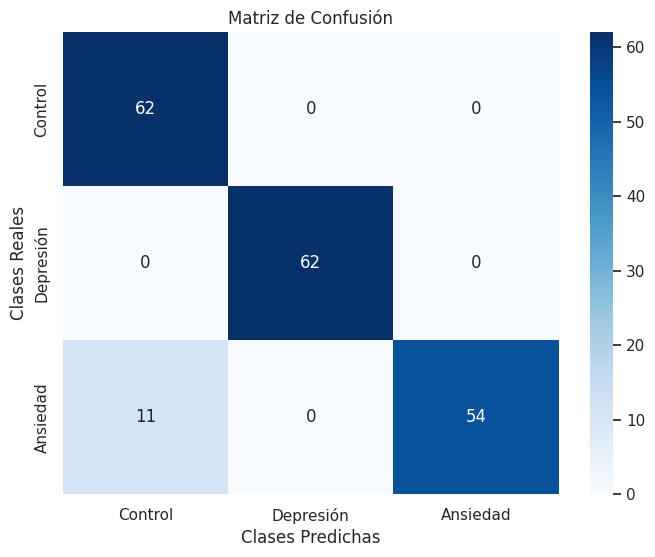

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir etiquetas de las clases
classes = ['Control', 'Depresión', 'Ansiedad']

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Agregar etiquetas y título
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.title('Matriz de Confusión')

plt.show()

#Modelo Arbol Aleatorio

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Crea un modelo de Random Forest
random_forest_model = RandomForestClassifier(
    n_estimators=300,  # Número de árboles
    max_depth=100,  # Profundidad máxima de los árboles
    random_state=42,  # Semilla aleatoria para reproducibilidad
    n_jobs=-1  # Utilizar todos los núcleos de la CPU para procesamiento en paralelo
)

# Entrena el modelo con los datos de entrenamiento
random_forest_model.fit(X_train, y_train)

# Realiza predicciones en los datos de validación
y_val_pred = random_forest_model.predict(X_val)

# Calcula e imprime la precisión del modelo en los datos de validación
accuracy = accuracy_score(y_val, y_val_pred)
print("Precisión (Validación): {:.2f}".format(accuracy))

# Calcula e imprime la precisión del modelo en los datos de validación
precision = precision_score(y_val, y_val_pred, average='weighted')
print("Precisión (Validación): {:.2f}".format(precision))

# Calcula e imprime la exhaustividad del modelo en los datos de validación
recall = recall_score(y_val, y_val_pred, average='weighted')
print("Exhaustividad (Validación): {:.2f}".format(recall))

# Calcula e imprime la puntuación F1 del modelo en los datos de validación
f1 = f1_score(y_val, y_val_pred, average='weighted')
print("Puntuación F1 (Validación): {:.2f}".format(f1))

# Calcula e imprime métricas en el conjunto de entrenamiento
y_train_pred = random_forest_model.predict(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_train = f1_score(y_train, y_train_pred, average='weighted')

print("\nMétricas en el conjunto de entrenamiento:")
print("Precisión: {:.2f}".format(precision_train))
print("Exhaustividad: {:.2f}".format(recall_train))
print("Puntuación F1: {:.2f}".format(f1_train))

Precisión (Validación): 0.91
Precisión (Validación): 0.92
Exhaustividad (Validación): 0.91
Puntuación F1 (Validación): 0.91

Métricas en el conjunto de entrenamiento:
Precisión: 1.00
Exhaustividad: 1.00
Puntuación F1: 1.00


In [ ]:
# Imprimir las métricas de entrenamiento
print(f'Accuracy entrenamiento: {accuracy_train * 100:.2f}%')
print(f'Precisión  entrenamiento: {precision_train * 100:.2f}%')
print(f'Recall  entrenamiento: {recall_train * 100:.2f}%')
print(f'Puntuación F1  entrenamiento: {f1_train * 100:.2f}%')
print('\n')
# Imprimir las métricas de validación
print(f'Accuracy  validación: {accuracy * 100:.2f}%')
print(f'Precisión  validación: {precision* 100:.2f}%')
print(f'Recall  validación: {recall* 100:.2f}%')
print(f'Puntuación F1 validación: {f1 * 100:.2f}%')

Accuracy entrenamiento: 100.00%
Precisión  entrenamiento: 100.00%
Recall  entrenamiento: 100.00%
Puntuación F1  entrenamiento: 100.00%


Accuracy  validación: 91.36%
Precisión  validación: 91.69%
Recall  validación: 91.36%
Puntuación F1 validación: 91.44%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = random_forest_model.predict(X_val)

#
cm = confusion_matrix(y_val, y_pred)


#
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)
print("Matriz de confusión: \n\n", cm, "\n")

Matriz de confusión: 

 [[26  0  2]
 [ 1 26  1]
 [ 3  0 22]] 



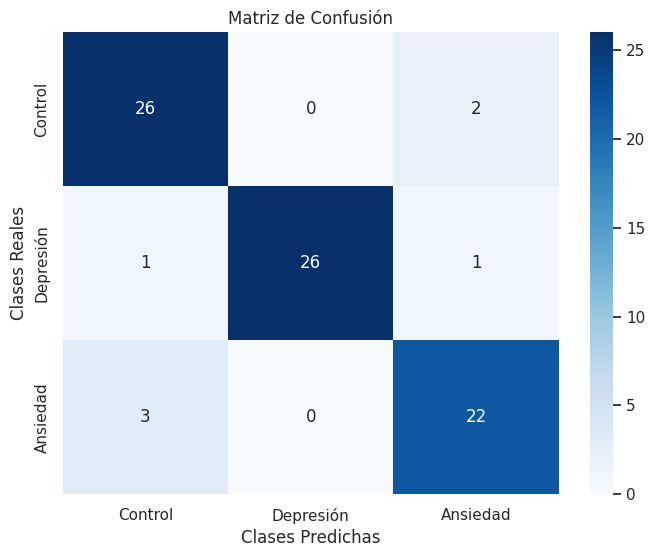

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir etiquetas de las clases
classes = ['Control', 'Depresión', 'Ansiedad']

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Agregar etiquetas y título
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.title('Matriz de Confusión')

plt.show()

#Modelo SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import os

# Suponiendo que ya tienes tus datos de entrenamiento y validación: X_train, X_val, y_train, y_val

# Crear un modelo SVM para clasificación multiclase con kernel polinómico
svm_model_p = SVC(kernel='linear', degree=4, C=100,max_iter=500000,  probability=False)

# Entrenar el modelo en los datos de entrenamiento
svm_model_p.fit(X_train, y_train)

# Predecir etiquetas en el conjunto de validación
y_val_pred = svm_model_p.predict(X_val)

# Calcular las métricas en el conjunto de validación
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='weighted')
recall = recall_score(y_val, y_val_pred, average='weighted')
f1 = f1_score(y_val, y_val_pred, average='weighted')

# Calcular y mostrar métricas en el conjunto de entrenamiento
y_train_pred = svm_model_p.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_train = f1_score(y_train, y_train_pred, average='weighted')

# Imprimir las métricas en el conjunto de entrenamiento
print("\nMétricas en el conjunto de entrenamiento:")
print("Exactitud (entrenamiento): {:.2%}".format(accuracy_train))
print("Precisión (entrenamiento): {:.2%}".format(precision_train))
print("Recall (entrenamiento): {:.2%}".format(recall_train))
print("F1-score (entrenamiento): {:.2%}".format(f1_train))
print('--'*50)
# Imprimir las métricas en el conjunto de validación
print("Exactitud en el conjunto de validación: {:.2%}".format(accuracy))
print("Precisión en el conjunto de validación: {:.2%}".format(precision))
print("Recall en el conjunto de validación: {:.2%}".format(recall))
print("F1-score en el conjunto de validación: {:.2%}".format(f1))



Métricas en el conjunto de entrenamiento:
Exactitud (entrenamiento): 100.00%
Precisión (entrenamiento): 100.00%
Recall (entrenamiento): 100.00%
F1-score (entrenamiento): 100.00%
----------------------------------------------------------------------------------------------------
Exactitud en el conjunto de validación: 90.12%
Precisión en el conjunto de validación: 90.30%
Recall en el conjunto de validación: 90.12%
F1-score en el conjunto de validación: 90.13%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = random_forest_model.predict(X_val)

#
cm = confusion_matrix(y_val, y_pred)


#
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)
print("Matriz de confusión: \n\n", cm, "\n")

Matriz de confusión: 

 [[26  0  2]
 [ 1 26  1]
 [ 3  0 22]] 



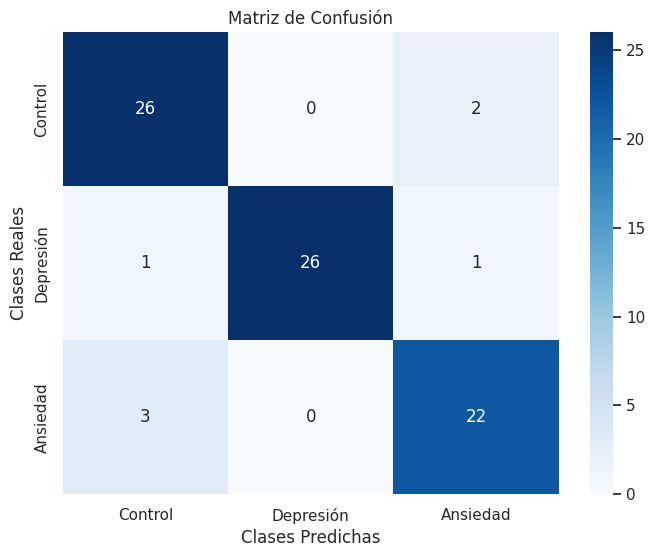

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir etiquetas de las clases
classes = ['Control', 'Depresión', 'Ansiedad']

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Agregar etiquetas y título
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.title('Matriz de Confusión')

plt.show()